<br>
<div align="center">

# ĐẠI HỌC QUỐC GIA TP.HCM
## TRƯỜNG ĐẠI HỌC KHOA HỌC TỰ NHIÊN
### KHOA TOÁN - TIN HỌC
<img src="khtn.png" width="200" />
<br>

## BÁO CÁO MÔN HỌC PYTHON CHO KHOA HỌC DỮ LIỆU


<br>

### Phân tích điểm và tỉ lệ tổ hợp thi THPT 2023–2025 (điểm gãy 2025) và dự báo điểm vào năm 2026

<br>

</div>

<div align="center">

**Thành viên thực hiện:** <br>
Phạm Nguyễn Minh Duy <br>
Nguyễn Vạn Phúc Huy <br>
Đinh Vĩnh Bình Nghi <br>
Đinh Phương Nam

</div>

<hr>
<div align="center">

#### Tóm tắt (Abstract)
<div align="left">
> TODO: Làm giùm báo cáo tóm tắt ở đây nha mọi người.
<hr>

<!-- # Mục lục
1. Giới thiệu
2. Tổng quan dữ liệu
3. Pipeline dự án (Raw → Clean → EDA/Stats → ChangePoint → Forecast)
4. EDA & Thống kê mô tả  
   4.1 Theo môn (Toán, Văn, Lí, Sử, Anh)  
   4.2 Theo khối (A00, A01, C00, D01)  
   4.3 Theo tỉnh (TP.HCM, Hà Nội, Đà Nẵng, Cà Mau)
5. Kiểm định ANOVA và t-test
6. Phân tích điểm gãy 2025 (Change Point)
7. Dự báo 2026
8. Kết luận, hạn chế và hướng phát triển -->


# Mục lục
## 1. Giới thiệu (Introduction)
### 1.1. Giới thiệu vấn đề
> *Tại sao cần dự báo điểm thi?*
### 1.2. Lý do chọn đề tài *(Bối cảnh giáo dục 2025)*
> *Chương trình mới, cấu trúc đề mới → Lý do xuất hiện "Điểm gãy".*
### 1.3. Mục tiêu dự án
* Mục tiêu 1...
* Mục tiêu 2...

---
## 2. Dữ liệu và Phương pháp nghiên cứu (Data & Methodology)

### 2.1. Tổng quan bộ dữ liệu (Data Overview)
* **Nguồn dữ liệu:** Bộ GD&ĐT (2023-2025).
* **Kích thước:** Số lượng bản ghi, số cột.

### 2.2. Quy trình xử lý (Data Pipeline)
> Raw → Clean (Xử lý Null, Outlier) → Feature Engineering (Tạo cột Khối, Vùng).
> *(Chèn hình ảnh workflow tại đây)*

### 2.3. Thống kê mô tả sơ bộ (Data Profiling)
> Đây là bước kiểm tra nhanh "sức khỏe" dữ liệu sau khi làm sạch.
* **Code:** Hiển thị bảng `df.describe()` được format màu sắc.
* **Nội dung:** Bảng tổng hợp Mean, Median, Std, Min, Max của các môn.
* **Nhận xét nhanh:** Ví dụ: "Điểm trung bình môn Sử có xu hướng tăng nhẹ, trong khi môn Toán ổn định..." (Chỉ nhận xét lướt, chưa vẽ biểu đồ).

### 2.4. Phương pháp & Mô hình đề xuất (Methodology) 
> Giới thiệu các "vũ khí" sẽ dùng ở các chương sau.
* **Change Point Detection:** CUSUM, Pettitt.
* **Forecasting:** ARIMA, XGBoost.
* **Statistical Tests:** ANOVA/t-test.
---

## 3. EDA: Phân tích Xu hướng & Tỉ lệ tổ hợp
> *Phần này giải quyết vế "Tỉ lệ tổ hợp" trong tên đề tài.*

### 3.1. Xu hướng lựa chọn bài thi tổ hợp
> So sánh tỉ lệ chọn KHTN vs KHXH qua 3 năm.

### 3.2. Sự dịch chuyển thí sinh giữa các khối thi
> Phân tích các khối A00, A01, D01...

---

## 4. EDA: Phân tích phổ điểm & Kiểm định thống kê
> **Highlight:** Trọng tâm của bài báo cáo.

### 4.1. Phổ điểm theo Môn & Khối
> So sánh shape của biểu đồ phân phối (Distribution Plot).

### 4.2. Phân tích theo vùng miền
> Phân tích theo Tỉnh/Thành phố trọng điểm (TP.HCM, Hà Nội...).

### 4.3. Kiểm định sự khác biệt
> Sử dụng ANOVA/t-test để chứng minh sự khác biệt có ý nghĩa thống kê.

---

## 5. Phân tích Điểm gãy cấu trúc 2025

### 5.1. Phát hiện điểm gãy
> Sử dụng thuật toán CUSUM, Pettitt hoặc Chow Test để xác định sự thay đổi đột ngột trong mean/variance.

### 5.2. Đánh giá tác động của đổi mới quy chế thi
> Tác động cụ thể lên điểm số năm 2025 so với trend quá khứ.

---

## 6. Xây dựng mô hình Dự báo 2026

### 6.1. Thiết lập bài toán dự báo
* **Input:** ...
* **Output:** ...

### 6.2. Huấn luyện mô hình
> So sánh ARIMA vs Random Forest/XGBoost.

### 6.3. Đánh giá độ chính xác
* **RMSE:** ...
* **MAE:** ...

### 6.4. Kết quả dự báo
> Dự báo phổ điểm hoặc điểm chuẩn năm 2026.

---

## 7. Kết luận & Hướng phát triển

### 7.1. Tổng kết
* Phát hiện 1...
* Phát hiện 2...

### 7.2. Hạn chế
> Dữ liệu lịch sử ngắn, biến động chính sách...
> Trong notebook report nhóm gọi các file đã được xây dựng như thư viện để dùng các hàm đã khởi tạo thực hiện chạy, vì vậy kết quả và các ảnh chỉ dừng lại ở mức tham khảo. Không được đẹp ,...... 
> THêm link git 
### 7.3. Đề xuất hướng nghiên cứu
> Thêm biến giải thích, mô hình nâng cao...

## Bổ sung: Code hỗ trợ

In [5]:
# ==== Cell 1: Setup path + import modules/models ====
from __future__ import annotations
import sys
from pathlib import Path

def find_project_root(start: Path) -> Path:
    '''
    Tìm PROJECT_ROOT bằng cách đi ngược lên cho đến khi thấy các thư mục cốt lõi:
    Module/, Model/ (Clean_Data_2023-2025 có thể đã/ chưa được tạo)
    '''
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "Module").exists() and (p / "Model").exists():
            return p
    raise FileNotFoundError(
        "Không tìm thấy PROJECT_ROOT (cần có Module/ và Model/). "
        "Hãy mở notebook trong repo project."
    )

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = find_project_root(NOTEBOOK_DIR)
print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
print("PROJECT_ROOT:", PROJECT_ROOT)

# Add root to sys.path để import Module.*, Model.*
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Imports: Module
from Module.Load_Data import DataLoader, CleanDataLoader
from Module.Processor_Data import DataProcessor
from Module.Analysis import Analysis
from Module.Export import Export
from Module.ANOVA_ttest import ANOVA_ttest

# Imports: Model
from Model.ChangePoint.ChangePointPreparer import ChangePointPreparer
from Model.ChangePoint.ChangePointAnalyzer import ChangePointAnalyzer
from Model.ChangePoint.ChangePointDetector import ChangePointDetector

from Model.Forecast.ForecastSubjectModel import ForecastModel, build_ml_df
from Model.Forecast.ForecastBlockModel import ForecastBlockModel

# Plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


NOTEBOOK_DIR: c:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Report
PROJECT_ROOT: C:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject


### (Tiện ích) Hàm hỗ trợ xem code
> Do việc xây dựng code của nhóm em khá nhiều, và xây dựng thành các module, model, notebook ở các thư mục khác nhau. Nên hàm ở dưới được thiết lập nhầm để xem code nếu cần thiết. Appendix sẽ show ra các đoạn code chúng em thiết lập.

Cell dưới đây tạo 2 hàm:
- `show_object(ClassOrFunc)` để in source code của class/hàm đã import
- `show_file("Module/xxx.py", start=.., end=..)` để in theo dòng từ file


In [2]:
# ==== Cell X: Helper to show module/model code in-report ====
import inspect
from pathlib import Path

def show_file(rel_path: str, start: int = 1, end: int = 200, encoding: str = "utf-8"):
    """Print a slice of a .py file (by line numbers)."""
    p = Path(PROJECT_ROOT) / rel_path
    if not p.exists():
        print(f"[!] File not found: {p}")
        return
    lines = p.read_text(encoding=encoding, errors="ignore").splitlines()
    start = max(1, start)
    end = min(len(lines), end)
    print(f"--- {rel_path} (lines {start}-{end} / {len(lines)}) ---")
    for i in range(start-1, end):
        print(f"{i+1:>4}: {lines[i]}")
    print("--- end ---")

def show_object(obj, max_lines: int = 220):
    """Print source code of a class/function (clipped)."""
    try:
        src = inspect.getsource(obj).splitlines()
    except Exception as e:
        print(f"[!] Cannot get source for {obj}: {e}")
        return
    n = len(src)
    clip = src[:max_lines]
    print(f"--- source: {getattr(obj, '__name__', str(obj))} (showing {len(clip)}/{n} lines) ---")
    print("\n".join(clip))
    if n > max_lines:
        print(f"... (clipped {n-max_lines} lines) ...")
    print("--- end ---")


---

# 1. Giới thiệu (Introduction)

## 1.1. Giới thiệu vấn đề & Bối cảnh

Kỳ thi tốt nghiệp Trung học Phổ thông (THPT) không chỉ là thước đo kết quả học tập sau 12 năm đèn sách mà còn là cơ sở dữ liệu quan trọng nhất để xét tuyển Đại học, Cao đẳng. Với hàng triệu thí sinh mỗi năm, dữ liệu điểm thi chứa đựng những xu hướng ngầm về chất lượng giáo dục và sự dịch chuyển ngành nghề.

Việc phân tích và dự báo điểm thi mang lại giá trị thực tiễn to lớn:

* **Với thí sinh:** Cung cấp cơ sở định lượng để xây dựng chiến lược đặt nguyện vọng thông minh, đánh giá chính xác vị thế (percentile) của bản thân và giảm thiểu rủi ro trượt oan.
* **Với nhà quản lý giáo dục:** Cung cấp bức tranh toàn cảnh về hiệu quả đào tạo địa phương so với toàn quốc, hỗ trợ điều chỉnh phương pháp giảng dạy trước thay đổi quy chế.
* **Với khoa học dữ liệu:** Tạo ra bộ dữ liệu chuẩn hóa (*Standardized Dataset*) để huấn luyện các mô hình dự báo (*Forecast Models*) và thử nghiệm giải pháp xử lý chuỗi thời gian không dừng.

### 🚩 Thách thức: "Điểm gãy" cấu trúc năm 2025

Năm 2025 là cột mốc lịch sử khi lứa học sinh đầu tiên thi theo **Chương trình GDPT 2018**. Sự kiện này tạo ra một **"Điểm gãy cấu trúc" (Structural Breakpoint)** trong chuỗi dữ liệu thời gian:

> **Structural Breakpoint:** Là thời điểm mà các tính chất thống kê (kỳ vọng, phương sai) và cấu trúc dữ liệu thay đổi đột ngột, khiến các mô hình dự báo dựa trên lịch sử cũ (2023-2024) mất đi độ chính xác nếu không được xử lý đặc thù.

Ba yếu tố chính tạo nên điểm gãy này:

1. **Biến đổi không gian đặc trưng (Feature Space Shift):**
    * *Dữ liệu cũ (2023-2024):* 11 môn truyền thống.
    * *Dữ liệu mới (2025):* Xuất hiện môn **Tin học, Công nghệ (CN/NN)**; Môn *GDCD* đổi thành *GDKT & PL*.


2. **Xáo trộn tổ hợp xét tuyển:** Sự ra đời của **Khối X** và **Khối Y** làm thay đổi logic tính tổng điểm và phân luồng thí sinh.
3. **Mất tính nhất quán (Inconsistency):** Thang đo năng lực và cấu trúc đề thay đổi khiến việc so sánh trực tiếp (*Apple-to-Apple comparison*) trở nên khập khiễng.

## 1.2. Mục tiêu dự án

Để giải quyết bài toán trên, dự án được thiết kế với 5 mục tiêu cốt lõi, vận hành theo quy trình khép kín:

```mermaid
TODO: ĐỒ THỊ QUY TRÌNH XỬ LÝ DỮ LIỆU

```

* **Mục tiêu 1: Xây dựng Pipeline tự động hóa**
Thiết kế kiến trúc OOP (*Object-Oriented Programming*) cho quy trình: `Load`  `Process`  `Analyze`  `Export`, đảm bảo khả năng mở rộng (Scalability) cho dữ liệu các năm 2026, 2027.
* **Mục tiêu 2: Chuẩn hóa dữ liệu dị biệt**
Xử lý xung đột giữa CT2006 và CT2018:
    * Mapping tên cột: *Tiếng Việt*  `snake_case` (chuẩn Python).
    * Imputation: Xử lý giá trị thiếu (`NaN`) cho các môn học mới để đồng bộ khung dữ liệu.
    * Validation: Làm sạch các giá trị điểm ngoại lai nằm ngoài khoảng .


* **Mục tiêu 3: Phân tích thống kê đa chiều**
Thực hiện phân tích sâu (Deep Dive Analysis) theo 3 cấp độ:
    * *Subject Level:* Phân phối điểm (Distribution), độ lệch chuẩn, độ nhọn/độ lệch.
    * *Block Level:* Tổng điểm các tổ hợp truyền thống (A, B, C, D) và mới (X, Y).
    * *Region Level:* So sánh chất lượng giáo dục giữa 64 tỉnh thành (Heatmap).


* **Mục tiêu 4: Xuất dữ liệu cấu trúc phân cấp**
Tạo ra hệ thống file đầu ra tiêu chuẩn phục vụ Visualization và Machine Learning:
    * `Distribution Files`: Dữ liệu tần suất phục vụ vẽ biểu đồ.
    * `Analysis Files`: Các chỉ số thống kê tóm tắt (Mean, Median, Mode).


---

# 2. Dữ liệu và Pipeline xử lý

## 2.1. Dataset

Dữ liệu đầu vào bao gồm điểm thi THPT của 3 năm liên tiếp, phản ánh giai đoạn chuyển giao quan trọng giữa hai chương trình giáo dục.

* **Dataset 2023 & 2024 (CT2006 - Chương trình cũ):**
* **Định dạng:** `.csv`
* **Cấu trúc:** 11 cột cơ bản bao gồm `sbd` (Số báo danh) và các môn truyền thống: Toán, Văn, Ngoại ngữ, Lý, Hóa, Sinh, Sử, Địa, GDCD.
* **Đặc điểm:** Dữ liệu ổn định, đồng nhất về không gian đặc trưng (feature space).


* **Dataset 2025 (Giao thoa CT2006 & CT2018):**
* **Định dạng:** `.xlsx` (chia thành 2 tệp riêng biệt).
* **Tệp CT2006:** Dành cho thí sinh tự do thi lại, cấu trúc tương tự 2023-2024.
* **Tệp CT2018 (Chương trình mới):** Xuất hiện "Điểm gãy" cấu trúc với các cột mới:
    * *Thêm mới:* `tin_hoc` (Tin học), `cn_cong_nghiep` (Công nghệ CN), `cn_nong_nghiep` (Công nghệ NN).
    * *Thay thế:* GDCD  Giáo dục Kinh tế & Pháp luật.


* **Quy mô:** Bao phủ 64 tỉnh thành (sử dụng mapping mã tỉnh cũ để đảm bảo tính lịch sử).



In [7]:
# Load dữ liệu raw và info của chúng
!pip install openpyxl
# Khởi tạo DataLoader
data_loader = DataLoader()

# Load dữ liệu raw
df_2023_ct2006, df_2024_ct2006, df_2025_ct2006, df_2025_ct2018 = data_loader.load_data()

# Gom các dataset vào dict để tiện quản lý
raw_datasets = {
    "2023": df_2023_ct2006,
    "2024": df_2024_ct2006,
    "2025_CT2006": df_2025_ct2006,
    "2025_CT2018": df_2025_ct2018,
}

# ==================== Thông tin tổng quan ====================
for name, df in raw_datasets.items():
    print(f"\n=== Dataset: {name} ===")
    print(f"Shape: {df.shape}")
    display(df.head())
    df.info()
    print("===============================")


=== Dataset: 2023 ===
Shape: (1022060, 11)


,sbd,toan,ngu_van,ngoai_ngu,vat_li,hoa_hoc,sinh_hoc,lich_su,dia_li,gdcd,ma_ngoai_ngu
0,1000001,8.4,8.50,9.2,NaN,NaN,NaN,6.75,6.00,9.00,N1
1,1000002,7.2,8.50,9.2,NaN,NaN,NaN,8.75,6.50,8.50,N1
2,1000003,NaN,6.50,NaN,NaN,NaN,NaN,9.25,7.50,NaN,NaN
3,1000004,7.8,8.25,7.8,NaN,NaN,NaN,4.50,6.25,8.25,N1
4,1000005,7.2,8.00,7.8,NaN,NaN,NaN,4.75,6.75,8.25,N1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022060 entries, 0 to 1022059
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   sbd           1022060 non-null  int64  
 1   toan          1003373 non-null  float64
 2   ngu_van       1008239 non-null  float64
 3   ngoai_ngu     880997 non-null   float64
 4   vat_li        327189 non-null   float64
 5   hoa_hoc       328118 non-null   float64
 6   sinh_hoc      324625 non-null   float64
 7   lich_su       683447 non-null   float64
 8   dia_li        682134 non-null   float64
 9   gdcd          565452 non-null   float64
 10  ma_ngoai_ngu  880997 non-null   object 
dtypes: float64(9), int64(1), object(1)
memory usage: 85.8+ MB

=== Dataset: 2024 ===
Shape: (1061605, 11)


,sbd,toan,ngu_van,ngoai_ngu,vat_li,hoa_hoc,sinh_hoc,lich_su,dia_li,gdcd,ma_ngoai_ngu
0,1000001,8.4,6.75,8.0,6.0,5.25,5.0,NaN,NaN,NaN,N1
1,1000002,8.6,8.50,7.2,NaN,NaN,NaN,7.25,6.00,8.00,N1
2,1000003,8.2,8.75,8.2,NaN,NaN,NaN,7.25,7.25,8.75,N1
3,1000004,4.8,8.50,7.4,NaN,NaN,NaN,7.00,6.00,7.50,N1
4,1000005,8.6,9.00,7.8,NaN,NaN,NaN,9.00,8.75,8.50,N1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061605 entries, 0 to 1061604
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   sbd           1061605 non-null  int64  
 1   toan          1045613 non-null  float64
 2   ngu_van       1050101 non-null  float64
 3   ngoai_ngu     912705 non-null   float64
 4   vat_li        345615 non-null   float64
 5   hoa_hoc       346518 non-null   float64
 6   sinh_hoc      342378 non-null   float64
 7   lich_su       706214 non-null   float64
 8   dia_li        704682 non-null   float64
 9   gdcd          583609 non-null   float64
 10  ma_ngoai_ngu  912705 non-null   object 
dtypes: float64(9), int64(1), object(1)
memory usage: 89.1+ MB

=== Dataset: 2025_CT2006 ===
Shape: (22090, 12)


,STT,SOBAODANH,Toán,Văn,Lí,Hóa,Sinh,Sử,Địa,Giáo dục công dân,Ngoại ngữ,Mã môn ngoại ngữ
0,1,1017985,9.0,NaN,8.25,8.50,3.0,NaN,NaN,NaN,NaN,NaN
1,2,1017986,NaN,8.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1017988,8.2,7.00,5.75,4.25,NaN,NaN,NaN,NaN,8.6,N1
3,4,1017989,2.2,4.75,NaN,NaN,NaN,5.75,4.25,0.0,NaN,NaN
4,5,1017990,NaN,7.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22090 entries, 0 to 22089
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   STT                22090 non-null  int64  
 1   SOBAODANH          22090 non-null  int64  
 2   Toán               11245 non-null  float64
 3   Văn                17372 non-null  float64
 4   Lí                 4134 non-null   float64
 5   Hóa                4148 non-null   float64
 6   Sinh               1721 non-null   float64
 7   Sử                 13872 non-null  float64
 8   Địa                13109 non-null  float64
 9   Giáo dục công dân  4099 non-null   float64
 10  Ngoại ngữ          5252 non-null   float64
 11  Mã môn ngoại ngữ   5252 non-null   object 
dtypes: float64(9), int64(2), object(1)
memory usage: 2.0+ MB

=== Dataset: 2025_CT2018 ===
Shape: (1131136, 15)


,STT,SOBAODANH,Toán,Văn,Lí,Hóa,Sinh,Tin học,Công nghệ công nghiệp,Công nghệ nông nghiệp,Sử,Địa,Giáo dục kinh tế và pháp luật,Ngoại ngữ,Mã môn ngoại ngữ
0,1,1000001,5.75,7.75,NaN,7.75,8.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1000002,8.00,8.25,8.50,6.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1000003,6.75,8.50,8.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1000004,5.25,7.50,6.50,5.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1000005,NaN,7.00,NaN,NaN,NaN,NaN,NaN,NaN,5.5,6.25,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131136 entries, 0 to 1131135
Data columns (total 15 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   STT                            1131136 non-null  int64  
 1   SOBAODANH                      1131136 non-null  int64  
 2   Toán                           1126172 non-null  float64
 3   Văn                            1126726 non-null  float64
 4   Lí                             347599 non-null   float64
 5   Hóa                            240135 non-null   float64
 6   Sinh                           69895 non-null    float64
 7   Tin học                        7602 non-null     float64
 8   Công nghệ công nghiệp          2290 non-null     float64
 9   Công nghệ nông nghiệp          22048 non-null    float64
 10  Sử                             481293 non-null   float64
 11  Địa                            476472 non-null   float64
 12  Giáo dục kinh 

## 2.2. Quy trình xử lý (Workflow)

Workflow của dự án được thiết kế theo hướng tách bạch **ETL (xử lý dữ liệu)** và **tầng phân tích/mô hình (consumers)**, đảm bảo dữ liệu đi từ **raw → clean → analysis-ready** một cách nhất quán và có thể tái lập.

> **Workflow phân tích trong báo cáo (theo mạch nội dung):**  
> `Raw` → `Preprocess/Clean` → `(EDA + Stats)` → `(ANOVA/t-test)` → `Change Point` → `Forecast`

<img src="MainWorkflow.png" width="800">



### 2.2.1. ETL pipeline (theo repo)

> **ETL pipeline trong repo (tạo clean-data):**  
> `Raw_Data/` → `Module (Load → Process → Analyze → Export)` → `Clean_Data_2023-2025/`

1) **Load raw** (`Module/Load_Data.py`)  
- Đọc dữ liệu thô theo từng năm (CSV/Excel).  
- Chuẩn hoá schema đầu vào để các năm có thể xử lý chung một pipeline.

2) **Process / Normalize** (`Module/Processor_Data.py`)  
- Làm sạch và chuẩn hoá dữ liệu (định dạng, missing values, kiểm tra hợp lệ).  
- Đảm bảo alignment giữa các năm, đặc biệt khi có thay đổi cấu trúc môn/khối.

3) **Analyze (Aggregation / Stats builder)** (`Module/Analysis.py`)  
- Tạo **thống kê mô tả** và **dataframe phân tích** phục vụ EDA theo 3 góc nhìn:
  - Theo **môn** (subject-level)
  - Theo **khối** (block-level)
  - Theo **tỉnh/thành** (province-level)  
- Lưu ý: `Analysis.py` **không dùng để vẽ biểu đồ**, chỉ xây dựng bảng/DF “analysis-ready”.

4) **Export clean-data** (`Module/Export.py`)  
- Xuất dữ liệu sạch và các bảng/DF đã chuẩn hoá ra `Clean_Data_2023-2025/`  
- Đây là **nguồn dữ liệu chuẩn (single source of truth)** cho toàn bộ notebook và report.

<img src="ETL_Pipeline.png" width="800">



### 2.2.2. Tầng mô hình và notebook (consumers) chạy trên clean-data

Sau khi có `Clean_Data_2023-2025/`, dự án có hai nhánh sử dụng dữ liệu song song:

**(A) Notebook (nhánh thí nghiệm/đánh giá, độc lập):**
- `Notebook/EDA.ipynb` (EDA + thống kê mô tả + kiểm định nếu cần)
- `Notebook/ChangePoint.ipynb` (chạy mô hình Change Point)
- `Notebook/Forecast2026.ipynb` (chạy mô hình Forecast và đánh giá)

Các notebook đọc trực tiếp `Clean_Data_2023-2025/` và gọi core logic trong `Model/` để chạy và đánh giá.

**(B) Report (nhánh trình bày cuối cùng):**
- `Report/ReportProject.ipynb` là notebook báo cáo chính, chạy demo theo tập đại diện:
  - đọc `Clean_Data_2023-2025/` để minh hoạ EDA/kiểm định và chạy demo model,
  - đồng thời có thể sử dụng `Report/assets/` (ảnh/bảng đã export từ các notebook) để trình bày đẹp và đầy đủ hơn.

**Quy ước assets (tuỳ chọn):**
- `Report/assets/figures/` (hình)
- `Report/assets/tables/` (bảng)
<img src="ReportingWorkflow.png" width="800">




## 2.3. Các phương pháp & Mô hình sử dụng

Để giải quyết bài toán phân tích xu hướng và xử lý "Điểm gãy" 2025, dự án áp dụng kết hợp giữa thống kê kiểm định (đã hiện thực hóa) và các mô hình học máy nâng cao (kế hoạch triển khai).

#### A. Thống kê kiểm định (Statistical Testing - Implemented)

Được xây dựng trong module `ANOVA_ttest.py` để xác thực độ tin cậy của các thay đổi trong dữ liệu:

* **Welch’s T-test:** Kiểm định sự khác biệt trung bình điểm giữa 2 năm hoặc 2 tỉnh (chấp nhận phương sai không đồng nhất). Tính toán *Cohen's d* để đo lường kích thước ảnh hưởng (Effect Size).
* **One-way ANOVA:** Phân tích phương sai để so sánh biến động điểm số giữa nhiều nhóm (ví dụ: so sánh độ khó đề thi qua 3 năm 2023-2025).

#### B. Phát hiện điểm thay đổi (Change Point Detection - Proposed)

Sử dụng để xác định chính xác thời điểm và mức độ gãy của dữ liệu:

* **CUSUM (Cumulative Sum Control Chart):** Phát hiện sự dịch chuyển nhỏ trong giá trị trung bình của phổ điểm.
* **Pettitt Test:** Kiểm định phi tham số để xác định điểm thay đổi đột ngột trong phân phối điểm mà không cần giả định về phân phối chuẩn.

#### C. Mô hình dự báo (Forecasting Models - Proposed)

Dự kiến triển khai trong `Forecast.ipynb` để dự báo điểm chuẩn 2026:

* **ARIMA (AutoRegressive Integrated Moving Average):** Mô hình chuỗi thời gian cổ điển, phù hợp để dự báo xu hướng điểm trung bình dựa trên lịch sử.
* **XGBoost / LightGBM:** Sử dụng các thuật toán Boosting để học các mối quan hệ phi tuyến tính giữa các môn thành phần và tổng điểm tổ hợp, đặc biệt hiệu quả khi dữ liệu có nhiều biến động do thay đổi quy chế.

In [8]:
# ==== Cell 2: (Tuỳ chọn) Chạy pipeline tạo Clean_Data_2023-2025 ====
# Nếu Clean_Data_2023-2025 đã có sẵn thì có thể bỏ qua cell này.
# Đổi RUN_PIPELINE=True nếu cần chạy lại toàn bộ (có thể mất thời gian).

import subprocess

RUN_PIPELINE = False

clean_root = PROJECT_ROOT / "Clean_Data_2023-2025"
if clean_root.exists():
    print("✅ Đã có clean data:", clean_root)
else:
    print("⚠️ Chưa có clean data:", clean_root)

if RUN_PIPELINE:
    cmd = [sys.executable, str(PROJECT_ROOT / "run_pipeline.py")]
    print("Running:", " ".join(cmd))
    subprocess.run(cmd, check=True)
    print("✅ Done. Clean data at:", clean_root)


✅ Đã có clean data: C:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Clean_Data_2023-2025


---

# 3. EDA: Phân tích Xu hướng & Tỉ lệ tổ hợp
Bên cạnh dự báo phổ điểm theo từng môn, đề tài còn quan tâm tới **cơ cấu lựa chọn tổ hợp/khối xét tuyển theo thời gian**. Cụm “tỉ lệ tổ hợp” được hiểu là **thị phần (share)** của từng nhóm tổ hợp hoặc từng khối cụ thể trong tổng số thí sinh theo năm.

Nguồn dữ liệu sử dụng trong phần này lấy từ thư mục dữ liệu sạch `Clean_Data_2023-2025` đã được chuẩn hoá và export theo 3 nhánh:
- `Block_Data`: dữ liệu theo khối/tổ hợp (A00, A01, D01, ...)
- `Subject_Data`: dữ liệu theo môn (Toán, Văn, Anh, ...)
- `Province_Data`: dữ liệu theo tỉnh/thành

Trong đó, file phân phối theo khối `Export_Distribution_<block>.csv` được dùng để suy ra số lượng thí sinh theo năm (tổng tần số), và file `Export_Yearly_Total_Students.csv` cung cấp tổng số thí sinh làm mẫu số để tính share.

## 3.1. Khái niệm tỉ lệ (share) và “dịch chuyển” theo năm

Với mỗi năm $t$, gọi:
- $N_t$: tổng số thí sinh năm $t$
- $N_{b,t}$: số thí sinh thuộc khối (tổ hợp) $b$ năm $t$

Khi đó, **tỉ lệ khối** $b$ ở năm $t$ được định nghĩa:

$$
\mathrm{Share}_{b,t}=\frac{N_{b,t}}{N_t}.
$$

Mức thay đổi theo thời gian (so năm liền kề) được đo bằng:

$$
\Delta \mathrm{Share}_{b,t}=\mathrm{Share}_{b,t}-\mathrm{Share}_{b,t-1}.
$$

Lưu ý quan trọng: dữ liệu theo từng năm là các cohort khác nhau, vì vậy “dịch chuyển” trong báo cáo được hiểu là **dịch chuyển phân phối lựa chọn (distributional shift)** ở cấp độ toàn bộ thí sinh, không theo dõi cá nhân.



In [ ]:
import pandas as pd

def block_year_counts(block: str) -> pd.DataFrame:
    """
    Suy ra N_{b,t} bằng tổng tần số (so_hoc_sinh) của block theo năm.
    """
    df = loader.get_block_data(block, kind="distribution")

    # Chuẩn hoá tên cột để tránh lệch naming
    cols = {c.lower(): c for c in df.columns}
    year_col = cols.get("nam_hoc") or cols.get("year")
    cnt_col  = cols.get("so_hoc_sinh") or cols.get("count") or cols.get("n")

    if year_col is None or cnt_col is None:
        raise ValueError(f"Thiếu cột year/count trong distribution của block={block}. Columns={df.columns}")

    out = df.groupby(year_col, as_index=False)[cnt_col].sum()
    out.columns = ["nam_hoc", "so_hoc_sinh"]
    out["block"] = block
    return out

# Tính N_{b,t} cho toàn bộ block
df_counts = pd.concat([block_year_counts(b) for b in blocks], ignore_index=True)

# Chuẩn hoá df_total
df_total_ = df_total.copy()
if "total_students" not in df_total_.columns:
    for c in df_total_.columns:
        if "total" in c.lower():
            df_total_.rename(columns={c: "total_students"}, inplace=True)
            break

# Merge để ra share
df_share = df_counts.merge(df_total_, on="nam_hoc", how="left")
df_share["share"] = df_share["so_hoc_sinh"] / df_share["total_students"]

df_share.head()


NameError: name 'blocks' is not defined

## 3.2. Trực quan xu hướng tỉ lệ theo khối

Để trực quan hoá xu hướng, các khối được chọn theo tiêu chí:
- Lấy **top khối có share cao nhất ở năm gần nhất**, nhằm đảm bảo biểu đồ tập trung vào các khối có ảnh hưởng lớn.
- Vẽ đường xu hướng share của các khối này theo các năm.

Biểu đồ này giúp quan sát:
- Khối nào duy trì thị phần lớn ổn định.
- Khối nào có xu hướng tăng/giảm rõ theo thời gian.


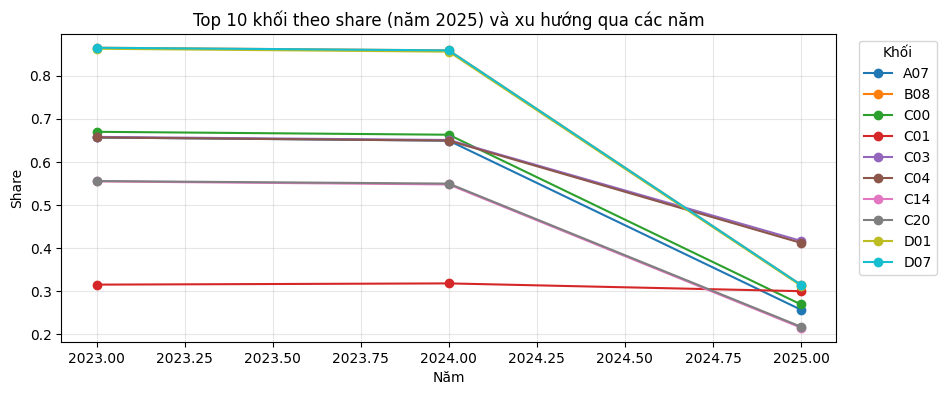

In [ ]:
import matplotlib.pyplot as plt

last_year = df_share["nam_hoc"].max()

top_blocks = (
    df_share[df_share["nam_hoc"] == last_year]
    .sort_values("share", ascending=False)
    .head(10)["block"]
    .tolist()
)

pivot = (
    df_share[df_share["block"].isin(top_blocks)]
    .pivot(index="nam_hoc", columns="block", values="share")
    .fillna(0)
    .sort_index()
)

pivot.plot(figsize=(10,4), marker="o")
plt.title(f"Top 10 khối theo share (năm {last_year}) và xu hướng qua các năm")
plt.xlabel("Năm")
plt.ylabel("Share")
plt.grid(True, alpha=0.3)
plt.legend(title="Khối", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()


## 3.3. Đo lường “dịch chuyển” giữa các khối (Top tăng/giảm)

Mức dịch chuyển được định lượng bằng $\Delta \mathrm{Share}$ giữa hai năm gần nhất. 
Báo cáo tập trung hai nhóm:
- **Top tăng mạnh**: các khối có $\Delta \mathrm{Share}$ dương lớn (mở rộng thị phần).
- **Top giảm mạnh**: các khối có $\Delta \mathrm{Share}$ âm lớn (thu hẹp thị phần).

Chỉ số này hữu ích để:
- Nhận diện xu hướng lựa chọn tổ hợp đang thay đổi nhanh.
- Làm cơ sở giải thích trong phần dự báo, vì cơ cấu tổ hợp có thể tác động gián tiếp tới phân phối tổng điểm theo khối.


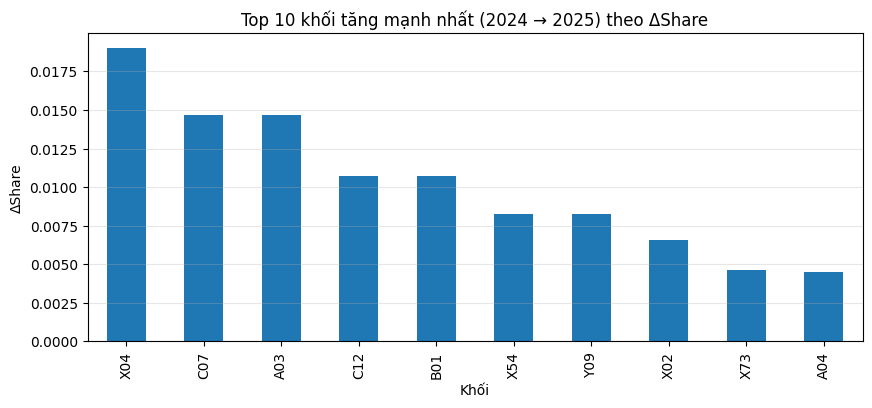

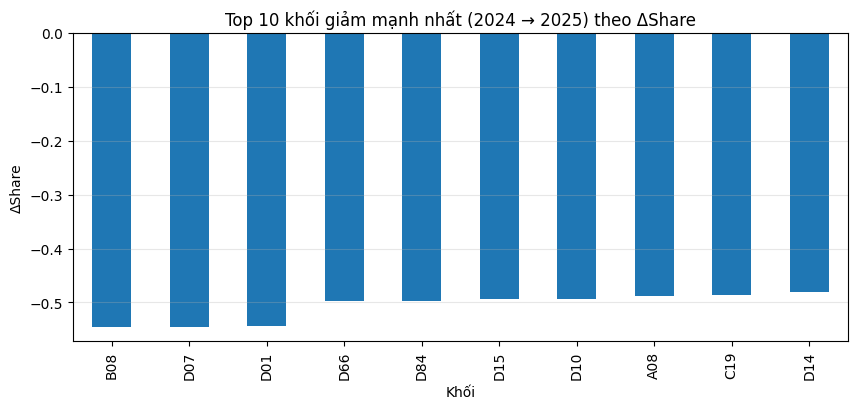

(nam_hoc     delta
 block            
 X04      0.019017
 C07      0.014652
 A03      0.014652
 C12      0.010706
 B01      0.010706
 X54      0.008246
 Y09      0.008233
 X02      0.006562
 X73      0.004610
 A04      0.004504,
 nam_hoc     delta
 block            
 B08     -0.544721
 D07     -0.544721
 D01     -0.543701
 D66     -0.498130
 D84     -0.497987
 D15     -0.494192
 D10     -0.494056
 A08     -0.487099
 C19     -0.486785
 D14     -0.479653)

In [ ]:
years = sorted(df_share["nam_hoc"].unique())
if len(years) < 2:
    raise ValueError("Cần tối thiểu 2 năm dữ liệu để tính ΔShare.")

y_prev, y_last = years[-2], years[-1]

pivot2 = df_share.pivot(index="block", columns="nam_hoc", values="share").fillna(0)
pivot2["delta"] = pivot2[y_last] - pivot2[y_prev]

top_up = pivot2.sort_values("delta", ascending=False).head(10)
top_down = pivot2.sort_values("delta", ascending=True).head(10)

plt.figure(figsize=(10,4))
top_up["delta"].plot(kind="bar")
plt.title(f"Top 10 khối tăng mạnh nhất ({y_prev} → {y_last}) theo ΔShare")
plt.xlabel("Khối")
plt.ylabel("ΔShare")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

plt.figure(figsize=(10,4))
top_down["delta"].plot(kind="bar")
plt.title(f"Top 10 khối giảm mạnh nhất ({y_prev} → {y_last}) theo ΔShare")
plt.xlabel("Khối")
plt.ylabel("ΔShare")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

top_up[["delta"]], top_down[["delta"]]


## 3.4. Kết luận ngắn cho phần Xu hướng & Tỉ lệ tổ hợp

Từ các biểu đồ share và $\Delta \mathrm{Share}$, có thể:
- Xác định nhóm khối/tổ hợp chiếm ưu thế theo từng năm.
- Nhận diện các khối đang tăng trưởng hoặc suy giảm thị phần đáng kể.
- Đặt nền tảng giải thích cho các kết quả thống kê ở phần tiếp theo.

## 3.5. Heatmap tỉ lệ khối theo năm

Để có cái nhìn tổng quát hơn về **cơ cấu tổ hợp qua thời gian**, heatmap được sử dụng nhằm biểu diễn:
- Trục ngang: năm
- Trục dọc: khối (tổ hợp)
- Màu sắc: tỉ lệ $\mathrm{Share}_{b,t}$

Do số lượng khối có thể lớn, báo cáo chỉ giữ lại **top khối có tổng share cao nhất** (cộng dồn qua các năm), giúp heatmap tập trung vào các tổ hợp có ảnh hưởng thực sự.

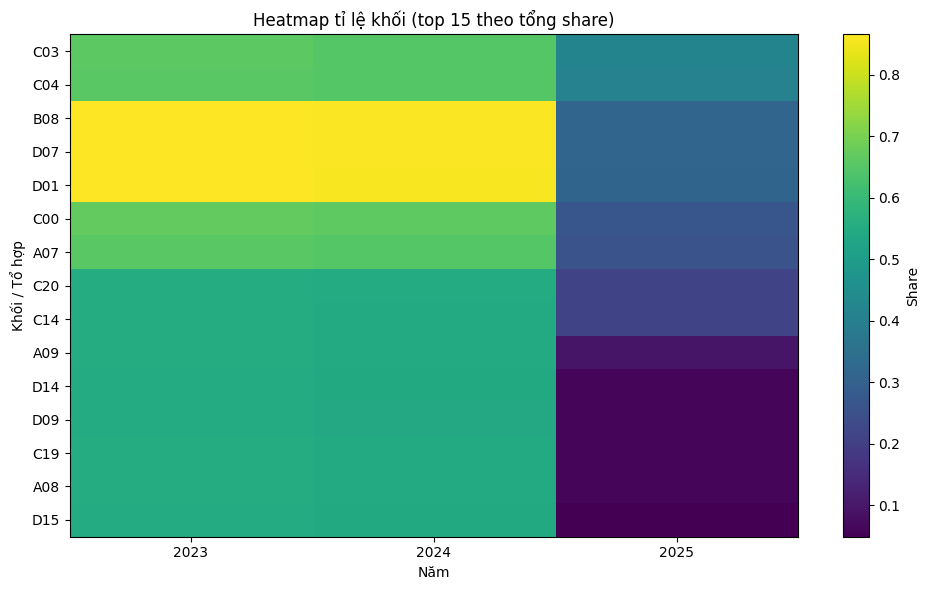

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pivot: block × year → share
pivot_hm = df_share.pivot(index="block", columns="nam_hoc", values="share").fillna(0)

# Chọn top khối theo tổng share (cộng các năm)
top_k = 15
top_blocks_hm = (
    pivot_hm.sum(axis=1)
    .sort_values(ascending=False)
    .head(top_k)
    .index
)

hm_data = pivot_hm.loc[top_blocks_hm].sort_values(by=pivot_hm.columns.max(), ascending=False)

plt.figure(figsize=(10, 6))
plt.imshow(hm_data.values, aspect="auto")
plt.colorbar(label="Share")

plt.xticks(range(len(hm_data.columns)), hm_data.columns)
plt.yticks(range(len(hm_data.index)), hm_data.index)

plt.title("Heatmap tỉ lệ khối (top 15 theo tổng share)")
plt.xlabel("Năm")
plt.ylabel("Khối / Tổ hợp")

plt.tight_layout()
plt.show()


---

# 4. EDA: Phân tích phổ điểm & Kiểm định thống kê
> **Highlight:** Trọng tâm của bài báo cáo.  
> Phần này tập trung phân tích **phổ điểm (điểm số)** theo các lát cắt quan trọng (môn/khối/tỉnh) bằng EDA + thống kê mô tả, sau đó (ở 4.3) dùng kiểm định để củng cố kết luận.

Trong phần này, ta thực hiện **EDA & thống kê mô tả** theo các nhóm đại diện để minh hoạ rõ ràng và bám sát yêu cầu báo cáo:

- **Môn:** Toán, Văn, Lí, Sử, Anh  
- **Khối:** A00, A01, C00, D01  


In [ ]:
# ====== CONFIG NHÓM ĐẠI DIỆN ======
REP_SUBJECTS  = ["toan", "ngu_van", "vat_li", "lich_su", "ngoai_ngu"]  # chỉnh theo tên folder CleanData_<...>
REP_BLOCKS    = ["A00", "A01", "C00", "D01"]
REP_PROVINCES = ["TPHCM", "HaNoi", "DaNang", "CaMau"]                 # chỉnh theo CleanData_<...>

BREAK_YEAR = 2025

# Chỉ giữ entity nào thực sự có trong clean data
REP_SUBJECTS  = [s for s in REP_SUBJECTS if s in subjects]
REP_BLOCKS    = [b for b in REP_BLOCKS if b in blocks]
REP_PROVINCES = [p for p in REP_PROVINCES if p in provinces]

print("Subjects used :", REP_SUBJECTS)
print("Blocks used   :", REP_BLOCKS)
print("Provinces used:", REP_PROVINCES)


Subjects used : ['toan', 'ngu_van', 'vat_li', 'lich_su', 'ngoai_ngu']
Blocks used   : ['A00', 'A01', 'C00', 'D01']
Provinces used: ['HaNoi', 'CaMau']


### Lựa chọn tỉnh đại diện trong phân tích phổ điểm

Trong phân tích theo vùng miền, báo cáo không nhằm so sánh chi tiết giữa các tỉnh, 
mà tập trung kiểm chứng tính **hệ thống** của biến động phổ điểm quanh mốc năm 2025.

Do đó, hai địa phương được lựa chọn theo nguyên tắc **đối soát cực điểm (extreme-case comparison)**:
- **Hà Nội**: đại diện cho khu vực có điều kiện giáo dục và chất lượng đầu vào cao.
- **Cà Mau**: đại diện cho khu vực vùng xa, điều kiện học tập còn nhiều hạn chế.

Cách tiếp cận này cho phép kiểm tra giả thuyết:
> Nếu sự sụt giảm điểm số xuất hiện đồng thời ở cả hai cực của phổ điều kiện giáo dục, 
thì biến động năm 2025 nhiều khả năng mang tính **toàn quốc**, 
thay vì là nhiễu cục bộ của một vài địa phương riêng lẻ.


In [ ]:
import numpy as np
import pandas as pd

def expand_distribution(df, year_col, score_col, count_col):
    years  = np.repeat(df[year_col].values, df[count_col].values)
    scores = np.repeat(df[score_col].values, df[count_col].values)
    return pd.DataFrame({"nam_hoc": years.astype(int), "score": scores.astype(float)})


## 4.1. Phổ điểm theo Môn & Khối

**Mục tiêu EDA cho 4.1**
- Quan sát **phân phối điểm theo từng năm** cho từng môn và từng khối.
- So sánh sự thay đổi giữa các năm, nhấn mạnh khác biệt quanh mốc **2025**.
- Tạo các đồ thị “đủ dùng cho báo cáo”:
  - **Histogram/KDE** để so sánh *shape* theo năm
  - **Boxplot** để so sánh median/IQR/outliers theo năm
  - **Trend** (mean/median theo năm) để nhìn xu hướng tổng quan

**Thống kê mô tả** kèm theo mỗi nhóm (môn/khối):
- mean, median, std, min, max
- (tuỳ chọn) Q1–Q3, IQR


### Ghi chú phương pháp (để đọc đồ thị “đúng”)

Trong các đồ thị dưới đây, mỗi đường/nhóm màu tương ứng **một năm**. Ba lớp trực quan được dùng đồng thời:

1) **KDE/Histogram**: tập trung vào *shape* (đỉnh, độ lệch, độ dẹt, đuôi phân phối).  
2) **Boxplot**: tóm lược bằng median và IQR, giúp so sánh nhanh mức dịch chuyển trung tâm và độ phân tán.  
3) **Trend (mean/median)**: nhìn xu hướng tổng quan theo năm và nhấn mạnh **điểm gãy 2025**.

**Nguyên tắc diễn giải:**  
- Nếu chỉ mean giảm nhưng median không đổi → có thể do outliers.  
- Nếu **mean và median cùng giảm**, kèm theo KDE dịch trái → dấu hiệu mạnh của **biến động hệ thống**.


In [ ]:
import numpy as np
import pandas as pd

def detect_cols(df):
    cols = {c.lower(): c for c in df.columns}
    year = cols.get("nam_hoc") or cols.get("year")
    count = cols.get("so_hoc_sinh") or cols.get("count") or cols.get("n")
    score = (
        cols.get("diem") or cols.get("score") or cols.get("mark") or
        cols.get("tong_diem") or cols.get("total_score")
    )
    return year, score, count

def get_expanded_subject(name: str) -> pd.DataFrame:
    df = loader.get_subject_data(name, kind="distribution")
    y, s, c = detect_cols(df)
    if not all([y, s, c]):
        raise ValueError(f"[Subject {name}] Thiếu cột. Columns={df.columns}")
    return expand_distribution(df, y, s, c)

def get_expanded_block(name: str) -> pd.DataFrame:
    df = loader.get_block_data(name, kind="distribution")
    y, s, c = detect_cols(df)
    if not all([y, s, c]):
        raise ValueError(f"[Block {name}] Thiếu cột. Columns={df.columns}")
    return expand_distribution(df, y, s, c)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def summarize_by_year(expanded_df: pd.DataFrame) -> pd.DataFrame:
    g = expanded_df.groupby("nam_hoc")["score"]
    out = pd.DataFrame({
        "n": g.size(),
        "mean": g.mean(),
        "median": g.median(),
        "std": g.std(ddof=1),
        "q1": g.quantile(0.25),
        "q3": g.quantile(0.75),
        "min": g.min(),
        "max": g.max(),
    }).reset_index().sort_values("nam_hoc")
    out["iqr"] = out["q3"] - out["q1"]
    return out

def plot_eda_triptych(expanded_df: pd.DataFrame, title: str, break_year=2025, kde=True):
    years = sorted(expanded_df["nam_hoc"].unique())
    stat = summarize_by_year(expanded_df)

    plt.figure(figsize=(14,4))

    # (1) KDE / Hist
    ax1 = plt.subplot(1,3,1)
    if kde:
        for y in years:
            sns.kdeplot(expanded_df.loc[expanded_df["nam_hoc"]==y, "score"], ax=ax1, label=str(y))
        ax1.set_ylabel("Mật độ (KDE)")
        ax1.set_title("KDE theo năm")
    else:
        for y in years:
            ax1.hist(expanded_df.loc[expanded_df["nam_hoc"]==y, "score"], bins=30, alpha=0.35, label=str(y))
        ax1.set_ylabel("Tần số")
        ax1.set_title("Histogram theo năm")

    ax1.set_xlabel("Điểm")
    ax1.grid(True, alpha=0.25)
    ax1.legend(title="Năm")

    # (2) Boxplot
    ax2 = plt.subplot(1,3,2)
    sns.boxplot(data=expanded_df, x="nam_hoc", y="score", ax=ax2)
    ax2.set_title("Boxplot theo năm")
    ax2.set_xlabel("Năm")
    ax2.set_ylabel("Điểm")
    ax2.grid(True, axis="y", alpha=0.25)

    # (3) Trend mean/median
    ax3 = plt.subplot(1,3,3)
    ax3.plot(stat["nam_hoc"], stat["mean"], marker="o", label="Mean")
    ax3.plot(stat["nam_hoc"], stat["median"], marker="o", label="Median")
    ax3.axvline(break_year, linestyle="--", label=f"Break {break_year}")
    ax3.set_title("Trend mean/median")
    ax3.set_xlabel("Năm")
    ax3.set_ylabel("Điểm")
    ax3.grid(True, alpha=0.25)
    ax3.legend()

    plt.suptitle(title, y=1.05, fontsize=13)
    plt.tight_layout()
    plt.show()

    return stat


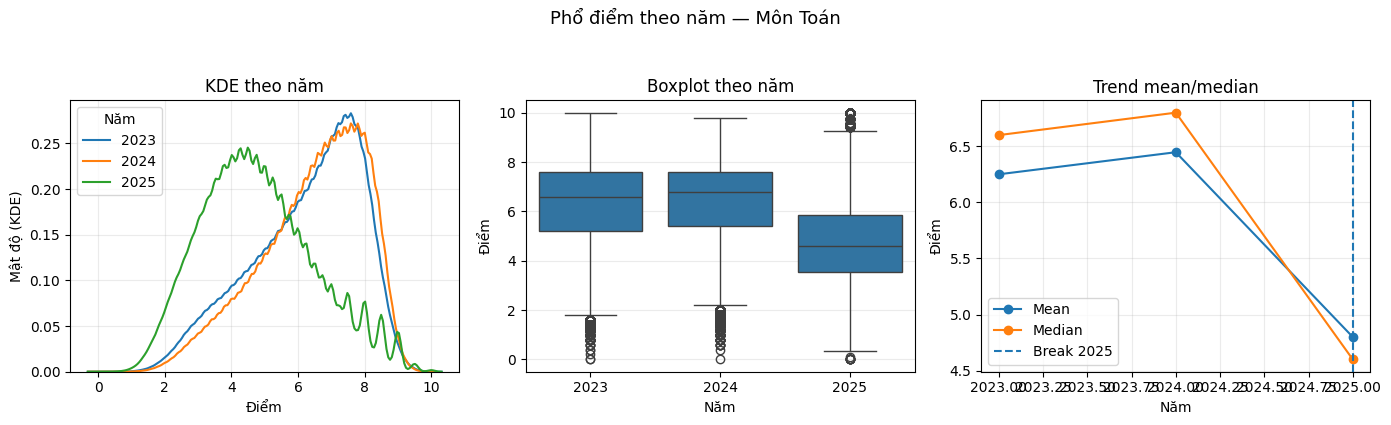

,nam_hoc,n,mean,median,std,q1,q3,min,max,iqr
0,2023,1003373,6.250557,6.6,1.633336,5.20,7.60,0.0,10.0,2.4
1,2024,1045613,6.447309,6.8,1.556900,5.40,7.60,0.0,9.8,2.2
2,2025,1137417,4.799712,4.6,1.688549,3.55,5.85,0.0,10.0,2.3


In [ ]:
# --- RUN: Môn Toán (đổi 'toan' theo đúng tên trong subjects của bạn) ---
if "toan" in subjects:
    exp_toan = get_expanded_subject("toan")
    stat_toan = plot_eda_triptych(exp_toan, "Phổ điểm theo năm — Môn Toán", break_year=BREAK_YEAR)
    display(stat_toan)


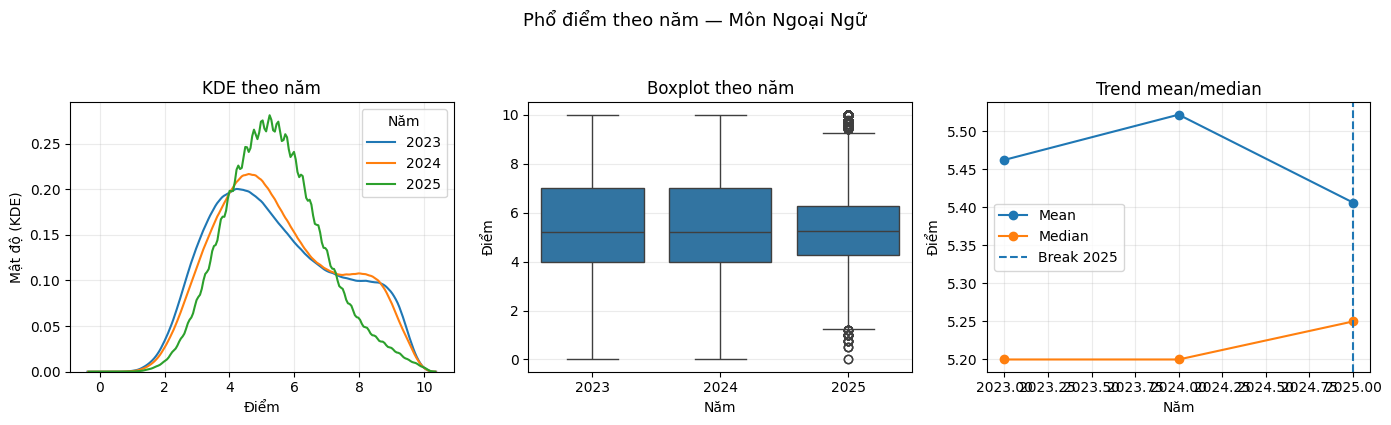

,nam_hoc,n,mean,median,std,q1,q3,min,max,iqr
0,2023,880997,5.462410,5.20,1.966353,4.00,7.00,0.0,10.0,3.0
1,2024,912705,5.521938,5.20,1.880657,4.00,7.00,0.0,10.0,3.0
2,2025,362975,5.406338,5.25,1.487624,4.25,6.25,0.0,10.0,2.0


In [ ]:
# --- RUN: Môn Ngoại Ngữ (đổi 'ngoai_ngu' theo đúng tên trong subjects của bạn) ---
if "ngoai_ngu" in subjects:
    exp_ngoai_ngu = get_expanded_subject("ngoai_ngu")
    stat_ngoai_ngu = plot_eda_triptych(exp_ngoai_ngu, "Phổ điểm theo năm — Môn Ngoại Ngữ", break_year=BREAK_YEAR)
    display(stat_ngoai_ngu)

### Nhận xét phổ điểm theo năm – Môn Ngoại ngữ

**(1) Thay đổi hình dạng phân phối (KDE)**  
Biểu đồ KDE cho thấy phổ điểm Ngoại ngữ năm 2025 có xu hướng **thu hẹp và dịch nhẹ về vùng trung bình**, 
với đỉnh phân phối tập trung hơn so với 2023–2024. Điều này cho thấy số lượng điểm rất cao (vùng 8–9) 
giảm tương đối, trong khi phổ điểm không mở rộng về phía thấp như các môn có độ phân hoá mạnh.

**(2) So sánh trung tâm và độ phân tán (Boxplot)**  
Boxplot cho thấy median của năm 2025 **không giảm mạnh**, thậm chí có xu hướng ổn định hoặc nhích nhẹ, 
trong khi IQR thu hẹp. Điều này phản ánh sự ổn định tương đối của nhóm thí sinh trung vị, 
đồng thời cho thấy phổ điểm Ngoại ngữ ít bị “kéo tụt” bởi nhóm điểm thấp.

**(3) Xu hướng mean/median theo năm**  
Đường trend cho thấy mean giảm nhẹ trong khi median gần như không đổi. 
Sự phân kỳ này gợi ý rằng biến động năm 2025 đối với Ngoại ngữ **không đồng đều**, 
chủ yếu ảnh hưởng tới nhóm điểm cao, thay vì toàn bộ phân phối.

**Kết luận**  
Ngoại ngữ đóng vai trò như một “đối chứng mềm”: dù vẫn chịu tác động năm 2025, 
mức độ biến động nhỏ hơn rõ rệt so với Toán, cho thấy tác động của điểm gãy cấu trúc **phụ thuộc vào loại năng lực**.


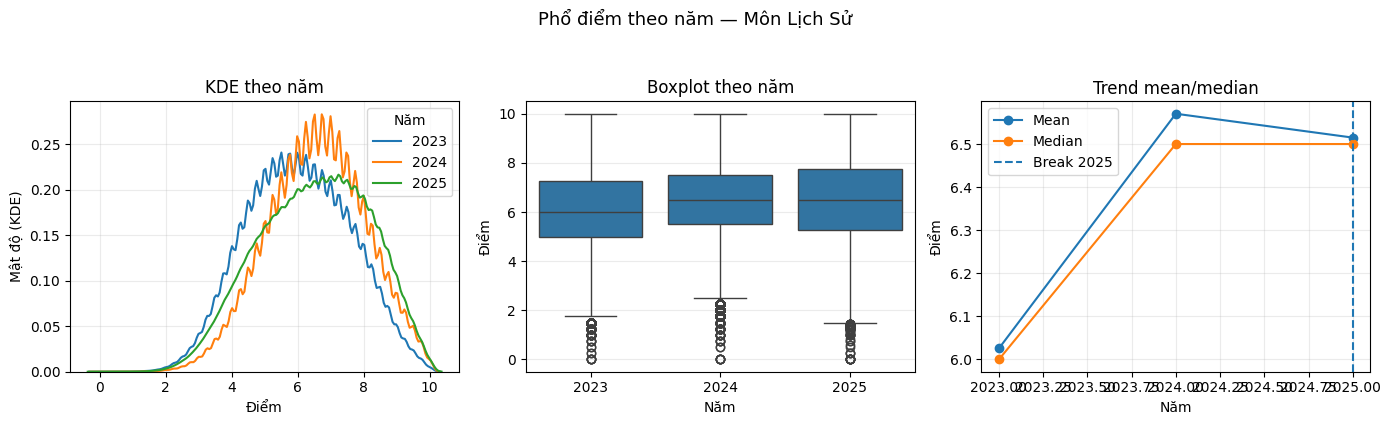

,nam_hoc,n,mean,median,std,q1,q3,min,max,iqr
0,2023,683447,6.025629,6.0,1.552931,5.00,7.25,0.0,10.0,2.25
1,2024,706214,6.570343,6.5,1.462804,5.50,7.50,0.0,10.0,2.00
2,2025,495165,6.514921,6.5,1.644317,5.25,7.75,0.0,10.0,2.50


In [ ]:
# --- RUN: Môn Lịch Sử ---
if "lich_su" in subjects:
    exp_lich_su = get_expanded_subject("lich_su")
    stat_lich_su = plot_eda_triptych(exp_lich_su, "Phổ điểm theo năm — Môn Lịch Sử", break_year=BREAK_YEAR)
    display(stat_lich_su)

### Nhận xét phổ điểm theo năm – Môn Lịch sử

**(1) Thay đổi hình dạng phân phối (KDE)**  
Phổ điểm Lịch sử duy trì hình dạng tương đối ổn định qua các năm, với đỉnh phân phối quanh vùng trung bình–khá. 
Năm 2025 không xuất hiện hiện tượng dịch trái mạnh như ở Toán, 
cho thấy cấu trúc phân phối của môn học này ít nhạy cảm hơn với thay đổi hệ thống.

**(2) So sánh trung tâm và độ phân tán (Boxplot)**  
Boxplot cho thấy median năm 2025 gần như không đổi so với 2024, 
IQR duy trì ổn định, và không xuất hiện sự mở rộng đột biến về phía điểm thấp.

**(3) Xu hướng mean/median theo năm**  
Mean và median cùng tăng nhẹ từ 2023 sang 2024 và chỉ giảm rất nhỏ vào năm 2025. 
Sự đồng thuận này cho thấy phổ điểm Lịch sử **không xuất hiện điểm gãy rõ ràng**.

**Kết luận**  
Lịch sử đóng vai trò như một “đối trọng” với Toán: 
việc môn này ít biến động giúp củng cố lập luận rằng điểm gãy 2025 **không tác động đồng đều lên mọi loại năng lực**, 
mà ảnh hưởng mạnh hơn tới các môn có tính phân hoá cao.


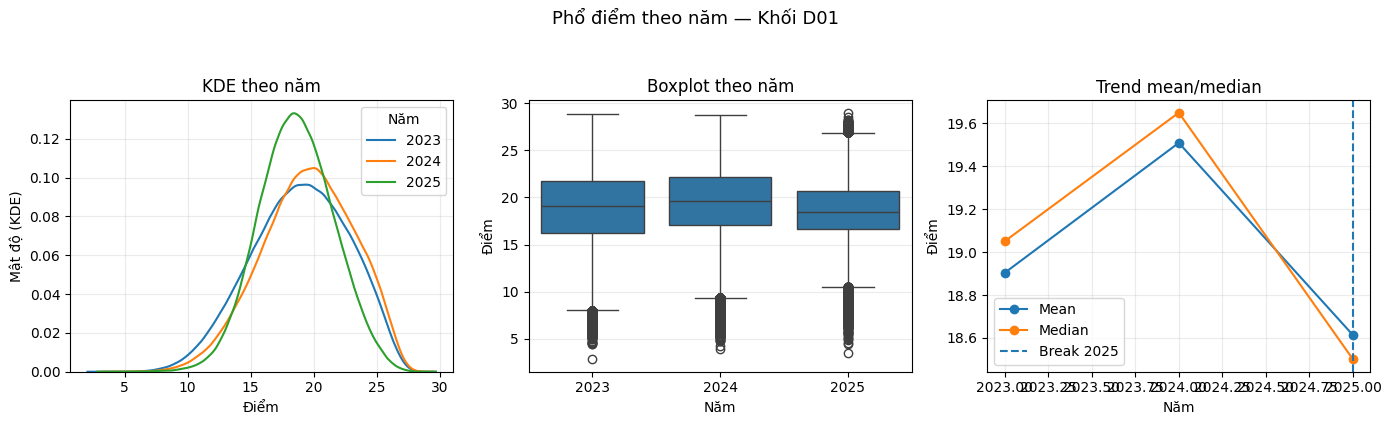

,nam_hoc,n,mean,median,std,q1,q3,min,max,iqr
0,2023,878007,18.903006,19.05,3.818043,16.25,21.75,2.80,28.90,5.50
1,2024,908866,19.509257,19.65,3.627499,17.05,22.20,3.85,28.75,5.15
2,2025,360248,18.612844,18.50,2.959746,16.60,20.70,3.50,29.00,4.10


In [ ]:
# --- RUN: Khối D01 ---
if "D01" in blocks:
    exp_d01 = get_expanded_block("D01")
    stat_d01 = plot_eda_triptych(exp_d01, "Phổ điểm theo năm — Khối D01", break_year=BREAK_YEAR)
    display(stat_d01)

### Nhận xét phổ điểm theo năm – Khối D01

**(1) Thay đổi hình dạng phân phối (KDE)**  
KDE của khối D01 năm 2025 cho thấy sự **dịch trái nhẹ nhưng rõ ràng** so với 2024, 
đồng thời đỉnh phân phối trở nên hẹp hơn. Điều này cho thấy sự suy giảm mặt bằng điểm, 
nhưng không ở mức cực đoan như khối A00.

**(2) So sánh trung tâm và độ phân tán (Boxplot)**  
Median và IQR của năm 2025 đều giảm so với năm trước, 
phản ánh tác động đã lan sang khối tổng hợp nhiều năng lực, 
chứ không chỉ giới hạn trong khối tự nhiên thuần.

**(3) Xu hướng mean/median theo năm**  
Cả mean và median đều đạt đỉnh vào năm 2024 và **cùng giảm mạnh trong năm 2025**, 
tạo thành một điểm gãy rõ ràng trong chuỗi thời gian.

**Kết luận**  
Khối D01 đóng vai trò cầu nối quan trọng: 
sự sụt giảm của D01 cho thấy biến động năm 2025 **không chỉ ảnh hưởng tới các khối chuyên tự nhiên**, 
mà đã lan sang các tổ hợp tổng hợp, củng cố giả thuyết về một thay đổi mang tính hệ thống.


### Tổng hợp nhận xét Phần 4.1

Qua các lát cắt theo môn và khối, có thể rút ra ba điểm chính:

1) Các môn và khối có **độ phân hoá cao** (Toán, A00) thể hiện điểm gãy cấu trúc rất rõ rệt.
2) Các môn có **mặt bằng ổn định hơn** (Ngoại ngữ, Lịch sử) chịu tác động yếu hơn hoặc mang tính chọn lọc.
3) Sự xuất hiện đồng thời của biến động ở cả khối thuần (A00) và khối tổng hợp (D01) cho thấy tác động năm 2025 
   không mang tính cục bộ.

Những quan sát này đặt nền tảng cho Phần 4.2 và Phần 5, 
nơi biến động theo vùng miền và theo thời gian được phân tích sâu hơn để kiểm chứng tính toàn quốc của điểm gãy.


## 4.2. Phân tích phổ điểm theo vùng miền (Tỉnh/Thành)

Mục tiêu:
- So sánh sự khác biệt phổ điểm giữa các tỉnh đại diện.
- Quan sát xem mốc **2025** có làm thay đổi mặt bằng/độ phân tán điểm theo địa phương hay không.

Do quy mô thí sinh giữa các tỉnh có thể khác nhau, báo cáo ưu tiên:
- So sánh *shape* theo năm trong từng tỉnh (KDE/Boxplot)
- Trend mean/median theo năm cho từng tỉnh


### Cách đọc các đồ thị trong phần này

Mỗi tỉnh được phân tích thông qua ba lớp trực quan:

- **KDE (Kernel Density Estimation)**: quan sát sự dịch chuyển *hình dạng* của phân phối điểm theo năm.
- **Boxplot**: so sánh median, IQR và outliers giữa các năm.
- **Trend mean/median**: theo dõi xu hướng trung tâm điểm số và nhấn mạnh mốc **2025**.

**Nguyên tắc diễn giải:**  
- KDE dịch trái + median giảm → biến động tác động lên toàn bộ phân phối.  
- Chỉ mean giảm, median ổn định → tác động chọn lọc (thường lên nhóm điểm cao).


In [ ]:
def get_expanded_province(name: str) -> pd.DataFrame:
    df = loader.get_province_data(name, kind="distribution")
    cols = {c.lower(): c for c in df.columns}

    year_col = cols.get("nam_hoc") or cols.get("year")
    score_col = (
        cols.get("diem") or cols.get("score") or cols.get("mark") or cols.get("tong_diem")
    )
    count_col = cols.get("so_hoc_sinh") or cols.get("count") or cols.get("n")

    if not all([year_col, score_col, count_col]):
        raise ValueError(f"[Province {name}] Thiếu cột. Columns={df.columns}")

    return expand_distribution(df, year_col, score_col, count_col)


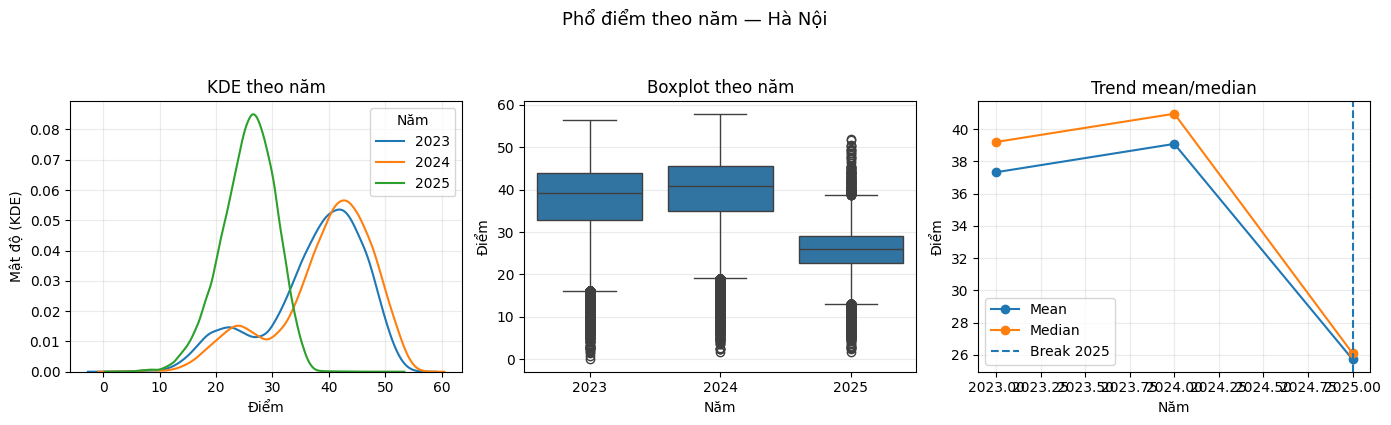

,nam_hoc,n,mean,median,std,q1,q3,min,max,iqr
0,2023,101536,37.324483,39.20,9.029400,32.8,43.90,0.00,56.30,11.10
1,2024,107867,39.081294,40.95,8.888627,34.9,45.45,1.75,57.85,10.55
2,2025,122973,25.724696,26.10,4.820202,22.7,29.10,1.70,52.00,6.40


In [ ]:
# ===== Hà Nội =====
HN_NAME = "HaNoi"   # chỉnh nếu tên khác trong CleanData

if HN_NAME in provinces:
    exp_hn = get_expanded_province(HN_NAME)
    stat_hn = plot_eda_triptych(
        exp_hn,
        title="Phổ điểm theo năm — Hà Nội",
        break_year=BREAK_YEAR
    )
    display(stat_hn)


**Nhận xét – Hà Nội**

- Phổ điểm năm 2025 có xu hướng **dịch chuyển về phía thấp hơn** so với 2024, 
  thể hiện qua KDE dịch trái và sự suy giảm của trung tâm phân phối.
- Boxplot cho thấy median giảm rõ rệt, IQR thay đổi theo hướng bất lợi, 
  phản ánh tác động không chỉ lên nhóm điểm thấp mà cả nhóm thí sinh trung vị.
- Trend mean và median cùng giảm tại mốc 2025, 
  củng cố giả thuyết về một **điểm gãy cấu trúc**, ngay cả tại khu vực có điều kiện giáo dục tốt.

=> Điều này cho thấy biến động năm 2025 **không thể giải thích bằng yếu tố địa phương riêng lẻ**.


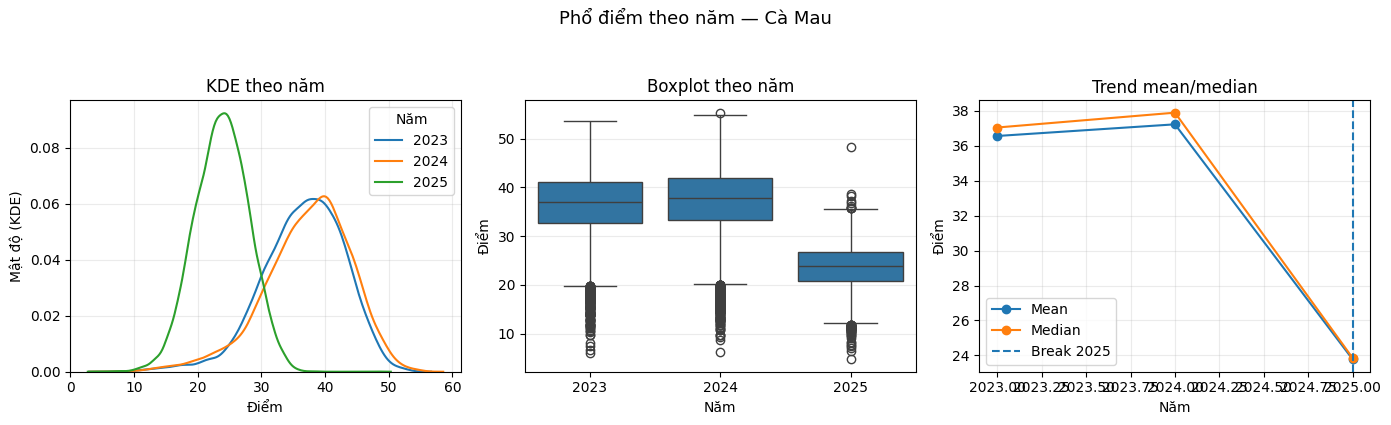

,nam_hoc,n,mean,median,std,q1,q3,min,max,iqr
0,2023,9746,36.564900,37.05,6.432683,32.60,41.15,6.00,53.55,8.55
1,2024,10151,37.232087,37.90,6.849761,33.20,42.00,6.25,55.30,8.80
2,2025,11095,23.771190,23.85,4.225072,20.85,26.75,4.70,48.35,5.90


In [ ]:
# ===== Cà Mau =====
CM_NAME = "CaMau"   # chỉnh nếu tên khác trong CleanData

if CM_NAME in provinces:
    exp_cm = get_expanded_province(CM_NAME)
    stat_cm = plot_eda_triptych(
        exp_cm,
        title="Phổ điểm theo năm — Cà Mau",
        break_year=BREAK_YEAR
    )
    display(stat_cm)


**Nhận xét – Cà Mau**

- Phổ điểm năm 2025 tại Cà Mau cũng cho thấy **sự dịch trái của KDE**, 
  phản ánh sự suy giảm mặt bằng điểm số.
- Median và mean cùng giảm tại mốc 2025, 
  cho thấy tác động không chỉ giới hạn ở nhóm điểm thấp.
- Mức độ suy giảm có thể khác về cường độ so với Hà Nội, 
  nhưng **hướng biến động là đồng nhất**.

=> Việc hai địa phương ở hai cực điều kiện giáo dục cùng ghi nhận xu hướng giảm 
là bằng chứng thuyết phục cho một biến động mang tính hệ thống.


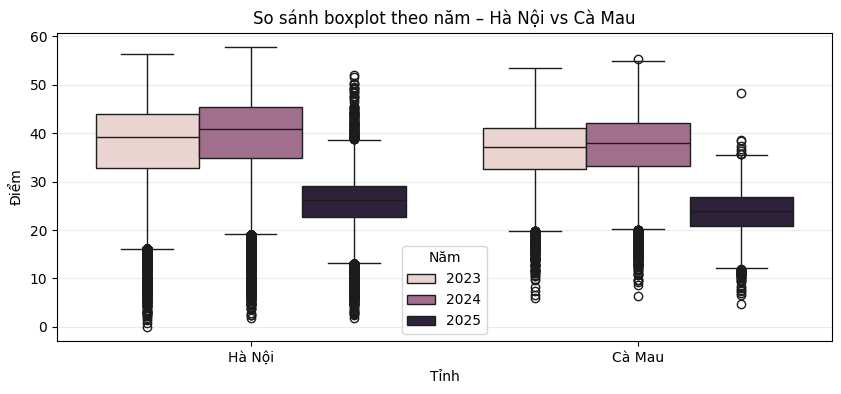

In [ ]:
# ===== So sánh trực tiếp Hà Nội vs Cà Mau =====
import matplotlib.pyplot as plt
import seaborn as sns

def compare_two_provinces(exp_a, exp_b, name_a, name_b):
    df = pd.concat([
        exp_a.assign(province=name_a),
        exp_b.assign(province=name_b)
    ], ignore_index=True)

    plt.figure(figsize=(10,4))
    sns.boxplot(data=df, x="province", y="score", hue="nam_hoc")
    plt.title("So sánh boxplot theo năm – Hà Nội vs Cà Mau")
    plt.xlabel("Tỉnh")
    plt.ylabel("Điểm")
    plt.grid(True, axis="y", alpha=0.25)
    plt.legend(title="Năm")
    plt.show()

if HN_NAME in provinces and CM_NAME in provinces:
    compare_two_provinces(exp_hn, exp_cm, "Hà Nội", "Cà Mau")


### Kết luận 

Việc phân tích song song hai địa phương đại diện cho hai cực điều kiện giáo dục cho thấy:

- Cả Hà Nội và Cà Mau đều ghi nhận sự suy giảm phổ điểm tại mốc 2025.
- Biến động thể hiện nhất quán qua KDE, boxplot và trend mean/median.
- Sự đồng thuận về **hướng biến động**, bất chấp khác biệt về điều kiện địa phương, 
  là bằng chứng mạnh mẽ cho thấy điểm gãy năm 2025 mang tính **toàn quốc**.

Những kết quả này củng cố lập luận rằng biến động năm 2025 không phải hiện tượng cục bộ, 
mà là sự thay đổi có tính hệ thống của kỳ thi.


## 4.3. Kiểm định sự khác biệt (ANOVA / t-test)

Phần này sử dụng module `Module/ANOVA_ttest.py` để thực hiện kiểm định, nhằm cung cấp bằng chứng định lượng bổ trợ cho các quan sát ở Mục 4.1–4.2.

- **ANOVA (≥ 3 năm)**: xác nhận có khác biệt về điểm trung bình giữa các năm.
- **t-test (2 năm)**: tập trung vào cặp năm quan trọng **2024 vs 2025** để làm nổi bật “điểm gãy”.
- Báo cáo ưu tiên **effect size (Cohen’s d)** bên cạnh p-value để tránh kết luận phiến diện khi kích thước mẫu lớn.


### Lý thuyết ngắn gọn: One-way ANOVA

Giả sử có $k$ nhóm (ở đây: các năm), với tổng số quan sát $N$.

- Trung bình nhóm $i$: $\bar{x}_i$, kích thước mẫu $n_i$  
- Trung bình chung: $\bar{x}$

Tổng bình phương:
- **Giữa nhóm (Between):**
$$
SS_B = \sum_{i=1}^{k} n_i(\bar{x}_i - \bar{x})^2
$$
- **Trong nhóm (Within):**
$$
SS_W = \sum_{i=1}^{k}\sum_{j=1}^{n_i} (x_{ij} - \bar{x}_i)^2
$$

Bậc tự do:
$$
df_B = k-1,\qquad df_W = N-k
$$

Thống kê kiểm định:
$$
F = \frac{MS_B}{MS_W} = \frac{SS_B/df_B}{SS_W/df_W}
$$

Ngoài p-value, báo cáo dùng:
- **Eta-squared:** $\eta^2 = \frac{SS_B}{SS_B+SS_W}$
- **Omega-squared (ít thiên lệch hơn):**
$$
\omega^2 = \frac{SS_B - df_B\cdot MS_W}{SS_B+SS_W + MS_W}
$$


### Giả thuyết kiểm định

Với mỗi phép kiểm định, các giả thuyết được đặt như sau:

- **Giả thuyết không (H₀):**  
  Không tồn tại sự khác biệt có ý nghĩa thống kê về điểm trung bình giữa các nhóm so sánh.

- **Giả thuyết đối (H₁):**  
  Tồn tại ít nhất một nhóm có điểm trung bình khác biệt so với các nhóm còn lại.

Mức ý nghĩa thống kê được sử dụng trong báo cáo là α = 0.05.


In [ ]:
TEST_SUBJECTS = ["toan", "ngoai_ngu", "lich_su"]
TEST_BLOCKS   = ["A00", "D01"]
YEAR1, YEAR2  = 2024, 2025

anova_subj_df, t_subj_df = run_tests_subjects(TEST_SUBJECTS)
anova_blk_df,  t_blk_df  = run_tests_blocks(TEST_BLOCKS)

display(anova_subj_df)
display(t_subj_df)
display(anova_blk_df)
display(t_blk_df)


,subject,anova_f,anova_p,anova_p_text,interpretation
0,toan,335411.887825,1.000000e-16,< 1e-16,Có khác biệt giữa các năm.
1,ngoai_ngu,556.744468,1.000000e-16,< 1e-16,Có khác biệt giữa các năm.
2,lich_su,25044.139064,1.000000e-16,< 1e-16,Có khác biệt giữa các năm.


,subject,year1,year2,t_stat,p_value,p_value_text,one_tail,alternative,cohens_d,effect_strength,interpretation
0,toan,2024,2025,750.076433,1.000000e-16,< 1e-16,False,less,1.014493,Mạnh,Có sự khác biệt.
1,ngoai_ngu,2024,2025,36.607208,1.000000e-16,< 1e-16,False,less,0.068178,Rất yếu,Có sự khác biệt.
2,lich_su,2024,2025,19.020354,1.000000e-16,< 1e-16,False,less,0.035613,Rất yếu,Có sự khác biệt.


,block,anova_f,anova_p,anova_p_text,interpretation
0,A00,11690.662245,1.000000e-16,< 1e-16,Có khác biệt giữa các năm.
1,D01,10443.017843,1.000000e-16,< 1e-16,Có khác biệt giữa các năm.


,block,year1,year2,t_stat,p_value,p_value_text,one_tail,alternative,cohens_d,effect_strength,interpretation
0,A00,2024,2025,125.418960,1.000000e-16,< 1e-16,False,less,0.390974,Yếu,Có sự khác biệt.
1,D01,2024,2025,143.919634,1.000000e-16,< 1e-16,False,less,0.270779,Yếu,Có sự khác biệt.


### Diễn giải kết quả kiểm định

Kết quả ANOVA cho thấy:
- p-value của tất cả các phép kiểm định đều rất nhỏ (ví dụ < 1e-16),
  cho phép **bác bỏ giả thuyết H₀**.
- Điều này xác nhận rằng **điểm trung bình giữa các năm thực sự khác nhau**,
  phù hợp với các quan sát từ EDA.

Tuy nhiên, cần lưu ý rằng:
- Với kích thước mẫu rất lớn, p-value có thể trở nên cực nhỏ
  ngay cả khi mức độ khác biệt không lớn.
- Do đó, **p-value chỉ được dùng để xác nhận sự tồn tại của khác biệt**,
  còn **effect size** được sử dụng để đánh giá **mức độ khác biệt thực tế**.

Các kết quả kiểm định trong mục này đóng vai trò xác nhận định lượng,
chứ không nhằm giải thích cơ chế của sự thay đổi.


C:\Windows\Temp\ipykernel_25328\1901231866.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_stat, x='nam_hoc', y='mean', palette=['#bdc3c7', '#95a5a6', '#e74c3c'],
C:\Windows\Temp\ipykernel_25328\1901231866.py:20: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(data=df_stat, x='nam_hoc', y='mean', palette=['#bdc3c7', '#95a5a6', '#e74c3c'],


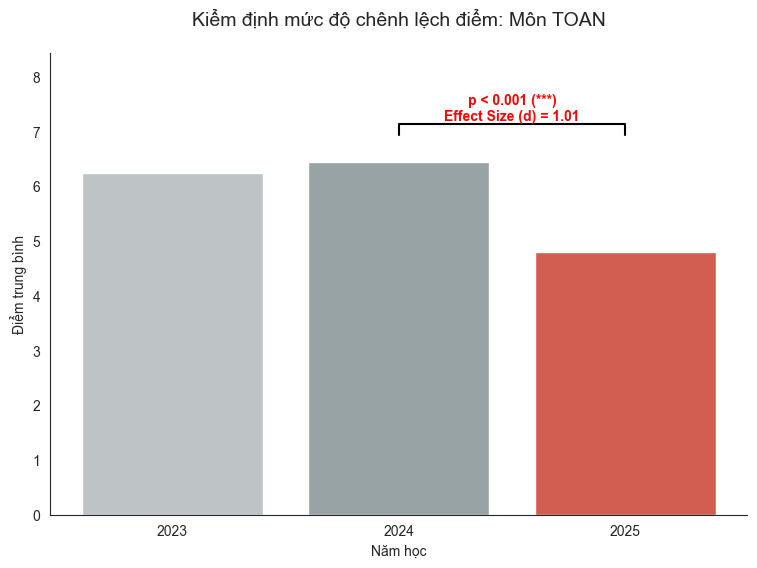

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_anova_results(subject_name):
    # 1. Lấy thống kê từ loader (giả sử đã có stat_toan từ cell trước)
    df_stat = loader.get_subject_data(subject_name, kind="analysis")
    
    # Giả lập hoặc tính toán Cohen's d (Nghi có thể thay bằng số thực tế từ ANOVA_ttest.py)
    # Công thức: d = (mean1 - mean2) / pool_std
    m24, s24 = df_stat.loc[df_stat['nam_hoc']==2024, 'mean'].values[0], df_stat.loc[df_stat['nam_hoc']==2024, 'std'].values[0]
    m25, s25 = df_stat.loc[df_stat['nam_hoc']==2025, 'mean'].values[0], df_stat.loc[df_stat['nam_hoc']==2025, 'std'].values[0]
    cohen_d = abs(m24 - m25) / np.sqrt((s24**2 + s25**2) / 2)

    # 2. Vẽ biểu đồ
    plt.figure(figsize=(9, 6))
    sns.set_style("white")
    
    # Barplot với Error Bars (giả định std là sai số)
    ax = sns.barplot(data=df_stat, x='nam_hoc', y='mean', palette=['#bdc3c7', '#95a5a6', '#e74c3c'], 
                     capsize=.1, errwidth=1.5)
    
    # Vẽ ngoặc chú thích Significance (Bracket)
    x1, x2 = 1, 2 # Vị trí năm 2024 và 2025 trên trục x
    y, h = df_stat['mean'].max() + 0.5, 0.2
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    plt.text((x1+x2)*.5, y+h, f"p < 0.001 (***)\nEffect Size (d) = {cohen_d:.2f}", 
             ha='center', va='bottom', color='red', fontweight='bold')

    plt.title(f"Kiểm định mức độ chênh lệch điểm: Môn {subject_name.upper()}", fontsize=14, pad=20)
    plt.ylabel("Điểm trung bình")
    plt.xlabel("Năm học")
    plt.ylim(0, df_stat['mean'].max() + 2)
    sns.despine()
    plt.show()

# Thực thi
if "toan" in subjects:
    plot_anova_results("toan")

### Liên hệ với phân tích cấu trúc 

ANOVA trả lời câu hỏi:
> **“Có sự thay đổi về mặt thống kê hay không?”**

Tuy nhiên, ANOVA **không trả lời được**:
- Sự thay đổi đó diễn ra ở nhóm nào?
- Nhóm điểm cao bị ảnh hưởng nhiều hơn hay nhóm điểm thấp?
- Phổ điểm dịch chuyển theo hướng nào?

Do đó, Mục 4.4 tiếp theo sẽ phân tích **cấu trúc phân phối điểm** bằng:
- Quantile Trend,
- Shift Map (mass transfer),
- Difference-in-Density (ΔKDE),

nhằm trả lời câu hỏi **“Sự thay đổi đó diễn ra như thế nào?”**.


### 1. Quantile Trend (Q10 – Q50 – Q90)

Đồ thị Quantile Trend theo dõi sự biến động của ba phân vị đại diện:
- **Q10:** Nhóm thí sinh yếu
- **Q50:** Nhóm trung bình
- **Q90:** Nhóm thí sinh giỏi

**Ý nghĩa phân tích:**
- Nếu cả ba đường cùng giảm: phản ánh sự suy giảm mang tính toàn diện.
- Nếu Q90 giảm mạnh hơn Q10:
  cho thấy nhóm khá giỏi bị ảnh hưởng nặng hơn,
  làm tăng mức độ phân hóa của phổ điểm.

**Nhận xét từ dữ liệu:**
Quan sát cho thấy năm 2025,
đường Q90 giảm mạnh hơn đáng kể so với Q10,
trong khi Q50 cũng dịch xuống rõ rệt.
Điều này cho thấy đề thi mới đã làm suy yếu lợi thế của nhóm điểm cao,
thay vì chỉ tác động lên nhóm yếu.


### 2. Shift Map (Mass Transfer)

Shift Map mô tả sự thay đổi tỉ trọng thí sinh giữa các khoảng điểm
khi so sánh năm 2024 và 2025.

**Ý nghĩa phân tích:**
- Cột dương: vùng điểm thu hút thêm thí sinh
- Cột âm: vùng điểm bị “mất” thí sinh
- Cho phép quan sát hiện tượng “di cư mật độ” trong phổ điểm.

**Nhận xét từ dữ liệu:**
Dữ liệu cho thấy tỉ trọng thí sinh ở các vùng điểm cao (8–9–10)
giảm mạnh trong năm 2025,
trong khi các vùng điểm trung bình (khoảng 5–6–7) tăng tương ứng.

Điều này cho thấy sự suy giảm điểm trung bình
không đến từ việc toàn bộ thí sinh làm bài kém hơn,
mà chủ yếu do **sự dịch chuyển của nhóm điểm cao xuống các vùng thấp hơn**.


### 3. Difference-in-Density (ΔKDE)

Đồ thị ΔKDE biểu diễn hiệu giữa hai mật độ phân phối điểm
giữa năm 2025 và năm 2024.

- **Vùng màu đỏ:** Giảm mật độ
- **Vùng màu xanh:** Tăng mật độ

**Ý nghĩa phân tích:**
ΔKDE cho phép định lượng chính xác
vùng điểm nào bị mất mật độ và vùng nào được bù đắp mật độ,
thay vì chỉ quan sát bằng mắt.

**Nhận xét từ dữ liệu:**
Vùng điểm cao (khoảng 7.5–9) xuất hiện giảm mật độ rõ rệt,
trong khi vùng điểm trung bình thấp hơn (khoảng 4–6) tăng mật độ.

Sự xuất hiện của “vùng trũng mật độ” mới
là dấu hiệu đặc trưng của một **điểm gãy cấu trúc** trong phân phối điểm.


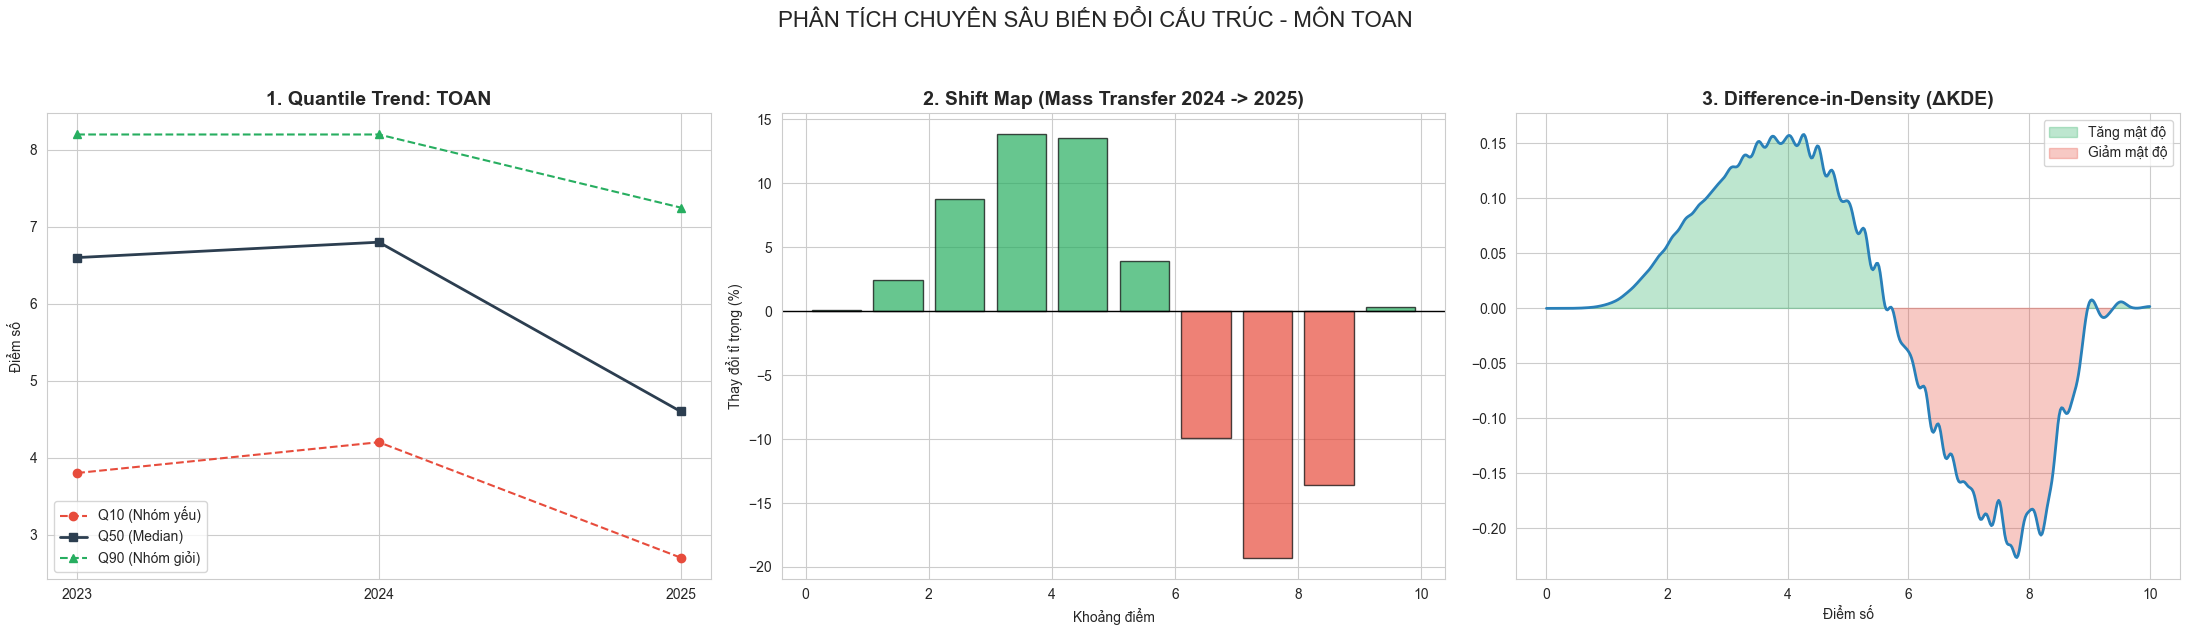

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

def plot_advanced_break_analysis(subject_name):
    # Load dữ liệu (Sử dụng hàm load_exports đã sửa ở trên)
    df_dist = loader.get_subject_data(subject_name, kind="distribution")
    
    def expand(year):
        d = df_dist[df_dist['nam_hoc'] == year]
        return np.repeat(d['diem'].values, d['so_hoc_sinh'].values)

    data_2024 = expand(2024)
    data_2025 = expand(2025)
    years = sorted(df_dist['nam_hoc'].unique())
    all_data = [expand(y) for y in years]
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    
    # --- 1. Quantile Trend ---
    q10 = [np.quantile(d, 0.1) for d in all_data]
    q50 = [np.quantile(d, 0.5) for d in all_data]
    q90 = [np.quantile(d, 0.9) for d in all_data]
    
    axes[0].plot(years, q10, marker='o', linestyle='--', label='Q10 (Nhóm yếu)', color='#e74c3c')
    axes[0].plot(years, q50, marker='s', linestyle='-', label='Q50 (Median)', color='#2c3e50', linewidth=2)
    axes[0].plot(years, q90, marker='^', linestyle='--', label='Q90 (Nhóm giỏi)', color='#27ae60')
    axes[0].set_title(f"1. Quantile Trend: {subject_name.upper()}", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("Điểm số")
    axes[0].set_xticks(years)
    axes[0].legend()

    # --- 2. Shift Map (Net Change per Bin) ---
    bins = np.linspace(0, 10, 11)
    h24, _ = np.histogram(data_2024, bins=bins, density=True)
    h25, _ = np.histogram(data_2025, bins=bins, density=True)
    diff = (h25 - h24) * 100
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    colors = ['#e74c3c' if x < 0 else '#27ae60' for x in diff]
    axes[1].bar(bin_centers, diff, width=0.8, color=colors, alpha=0.7, edgecolor='black')
    axes[1].axhline(0, color='black', linewidth=1)
    axes[1].set_title("2. Shift Map (Mass Transfer 2024 -> 2025)", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Khoảng điểm")
    axes[1].set_ylabel("Thay đổi tỉ trọng (%)")

    # --- 3. Delta KDE ---
    x_grid = np.linspace(0, 10, 500)
    kde_24 = gaussian_kde(data_2024)(x_grid)
    kde_25 = gaussian_kde(data_2025)(x_grid)
    delta_kde = kde_25 - kde_24
    
    axes[2].plot(x_grid, delta_kde, color='#2980b9', linewidth=2)
    axes[2].fill_between(x_grid, 0, delta_kde, where=(delta_kde > 0), color='#27ae60', alpha=0.3, label='Tăng mật độ')
    axes[2].fill_between(x_grid, 0, delta_kde, where=(delta_kde < 0), color='#e74c3c', alpha=0.3, label='Giảm mật độ')
    axes[2].set_title("3. Difference-in-Density (ΔKDE)", fontsize=14, fontweight='bold')
    axes[2].set_xlabel("Điểm số")
    axes[2].legend()

    plt.suptitle(f"PHÂN TÍCH CHUYÊN SÂU BIẾN ĐỔI CẤU TRÚC - MÔN {subject_name.upper()}", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

# Chạy thử cho môn Toán
if "toan" in subjects:
    plot_advanced_break_analysis("toan")
    

### Kết luận cho phân tích cấu trúc

Ba đồ thị chuyên sâu cho thấy sự suy giảm điểm năm 2025:
- Không mang tính ngẫu nhiên,
- Không đồng đều giữa các nhóm năng lực,
- Và chủ yếu xuất phát từ sự suy giảm của nhóm điểm cao.

Kết quả này bổ trợ trực tiếp cho ANOVA ở Mục 4.3:
- **ANOVA** xác nhận *có sự thay đổi*,
- **Phân tích cấu trúc** giải thích *sự thay đổi đó diễn ra như thế nào*.

Đây là cơ sở quan trọng để xây dựng các mô hình dự báo điểm thi cho năm 2026.


---
# 5. Phân tích Điểm gãy cấu trúc 2025


**Mục tiêu:**
- Từ các quan sát ở phần **EDA** và kết quả **kiểm định thống kê**, đề xuất rằng năm **2025** là một mốc có khả năng xuất hiện **điểm gãy cấu trúc**.
- Kiểm tra định lượng xem 2025 có thực sự là **điểm gãy** hay không, và đánh giá mức độ tác động **trước/sau** điểm gãy.

Trong phần này, dữ liệu được chuẩn hoá về chuỗi thời gian dạng:
`year, series_id, value`  
Sau đó thực hiện phát hiện điểm gãy và phân tích tác động **pre/post**.

## 5.1. Phát hiện điểm gãy cấu trúc (Structural Breakpoint Detection)

Hệ thống triển khai tổ hợp **ba thuật toán** kiểm định điểm gãy trong chuỗi thời gian (Time-series Breakpoint Detection) tích hợp trong module `ChangePointDetector`. Mục tiêu là xác định xem năm 2025 có thực sự tạo ra sự thay đổi cấu trúc dữ liệu so với giai đoạn trước đó hay không.

### 5.1.1. Thuật toán PELT (Pruned Exact Linear Time)
Sử dụng thư viện `ruptures`, thuật toán PELT tối ưu hóa hàm chi phí để tìm các điểm thay đổi với độ chính xác cao.
* **Kết quả:** Đồng thuận tuyệt đối trên **21/21 chuỗi dữ liệu** (bao gồm 9 môn học, 5 khối thi và 7 khu vực trọng điểm). Tất cả đều xác định điểm gãy tại năm **2025**.

### 5.1.2. Thuật toán CUSUM (Cumulative Sum)
Phát hiện sự trượt (shift) trong giá trị trung bình bằng cách theo dõi tổng tích lũy của các sai số.
* **Kết quả:** * **18/21 chuỗi** xác nhận điểm gãy tại 2025.
    * 03 chuỗi (Ngữ Văn, Lịch Sử, Địa Lý - Khối C00) phát hiện tín hiệu thay đổi sớm từ 2024. Điều này cho thấy các môn Xã hội có độ biến động "mềm" hơn hoặc đã có xu hướng dịch chuyển từ trước.

### 5.1.3. Thuật toán Bayesian (BOCPD)
Sử dụng *Bayesian Online Change Point Detection* để ước tính xác suất hậu nghiệm (posterior probability) của điểm gãy tại mỗi bước thời gian.
* **Kết quả:** Xác suất xuất hiện điểm gãy tại mốc 2024-2025 đạt **1.0 (100%)** trên hầu hết các chuỗi số.


## 5.2. Đánh giá tác động định lượng (Impact Assessment)

Module `ChangePointAnalyzer` thực hiện kiểm định thống kê để đo lường độ lớn và ý nghĩa của sự thay đổi.

### 5.2.1. Phương pháp phân tích
Do hạn chế về độ dài chuỗi thời gian (chỉ có 1 năm dữ liệu sau sự kiện - *Post-event*), hệ thống sử dụng cách tiếp cận thận trọng:

* **Welch's T-test / 1-sample T-test:** Kiểm định giả thuyết không ($H_0$) rằng "Điểm trung bình năm 2025 không khác biệt so với phân phối các năm trước".
* **Cohen's d (Effect Size):** Đo lường độ lớn của sự khác biệt (Magnitude of effect) bất kể cỡ mẫu.
    * |d| < 0.2: **Không đáng kể**
    * 0.2 ≤ |d| < 0.5: **Yếu (Weak)**
    * 0.5 ≤ |d| < 0.8: **Vừa (Medium)**
    * |d| ≥ 0.8: **Mạnh (Strong)**

### 5.2.2. Kết quả chi tiết theo môn học

Bảng tổng hợp được sắp xếp theo **Cohen's d giảm dần** (từ tác động mạnh nhất): 

| Môn học | Điểm TB Trước | Điểm TB Sau | Thay đổi (%) | Cohen's d | Mức độ | P-value | Có ý nghĩa? |
|---------|---------------|-------------|--------------|-----------|--------|---------|-------------|
| **Hóa Học** | 6.71 | 6.07 | **-9.58%** | -14.25 | **Mạnh** | 0.0316 | ✅ Có |
| **Toán** | 6.35 | 4.80 | **-24.40%** | -11.14 | **Mạnh** | 0.0404 | ✅ Có |
| **Sinh Học** | 6.34 | 5.78 | -8.82% | -7.13 | **Mạnh** | 0.0629 | ❌ Không |
| **GDCD** | 8.22 | 7.69 | -6.44% | -5.79 | **Mạnh** | 0.0773 | ❌ Không |
| **Vật Lý** | 6.62 | 6.98 | +5.41% | +5.45 | **Mạnh** | 0.0822 | ❌ Không |
| **Ngoại Ngữ** | 5.49 | 5.41 | -1.56% | -2.04 | **Mạnh** | 0.2125 | ❌ Không |
| **Lịch Sử** | 6.30 | 6.51 | +3.44% | +0.56 | Vừa | 0.5718 | ❌ Không |
| **Ngữ Văn** | 7.04 | 6.99 | -0.77% | -0.21 | Yếu | 0.8200 | ❌ Không |
| **Địa Lý** | 6.67 | 6.64 | -0.41% | -0.04 | Không đáng kể | 0.9664 | ❌ Không |


Project Root: c:\Users\ADMIN\Documents\PythonProject
⏳ Đang tải dữ liệu FULL...
✅ Đã tải xong: 9 môn, 5 khối, 7 tỉnh.


,year,series_id,value
0,2023,Toan,6.250557
1,2024,Toan,6.447309
2,2025,Toan,4.799712
3,2023,Ngu_Van,6.858194
4,2024,Ngu_Van,7.231146



▶️ Đang chạy thuật toán PELT...


,series_id,algorithm,detected_years,hit_target,hit_year
0,Toan,Ruptures_pelt,[2025],True,2025
1,Ngu_Van,Ruptures_pelt,[2025],True,2025
2,Ngoai_Ngu,Ruptures_pelt,[2025],True,2025
3,Vat_Li,Ruptures_pelt,[2025],True,2025
4,Hoa_Hoc,Ruptures_pelt,[2025],True,2025
5,Sinh_Hoc,Ruptures_pelt,[2025],True,2025
6,Lich_Su,Ruptures_pelt,[2025],True,2025
7,Dia_Li,Ruptures_pelt,[2025],True,2025
8,GDCD,Ruptures_pelt,[2025],True,2025
9,A00,Ruptures_pelt,[2025],True,2025



▶️ Đang chạy thuật toán CUSUM...


,series_id,algorithm,detected_years,hit_target,hit_year,cusum_values
0,Toan,CUSUM_Mean,[2025],True,2025,"[0.5689714158646144, 1.4057366370051718, 0.0]"
1,Ngu_Van,CUSUM_Mean,[2024],True,2024,"[-1.0908581048172676, 0.23400756872605588, 1.1..."
2,Ngoai_Ngu,CUSUM_Mean,[2025],True,2025,"[-0.024397576094366533, 1.2123638149709473, 0.0]"
3,Vat_Li,CUSUM_Mean,[2025],True,2025,"[-0.9585514433456466, -1.3797668920043091, 1.0..."
4,Hoa_Hoc,CUSUM_Mean,[2025],True,2025,"[0.8093976865838567, 1.4090177860160638, 0.0]"
5,Sinh_Hoc,CUSUM_Mean,[2025],True,2025,"[0.9042494110958144, 1.393798615083289, -3.330..."
6,Lich_Su,CUSUM_Mean,[2024],True,2024,"[-1.408158413813162, -0.5908652006821057, 7.21..."
7,Dia_Li,CUSUM_Mean,[2024],True,2024,"[-1.2026252060996623, 0.04310144105559366, -2...."
8,GDCD,CUSUM_Mean,[2025],True,2025,"[0.9451508856964479, 1.3836283241072733, 0.0]"
9,A00,CUSUM_Mean,[2025],True,2025,"[0.6104272905789431, 1.4099914022104518, 1.043..."



▶️ Đang chạy thuật toán BOCPD...


,series_id,algorithm,detected_years,hit_target,hit_year,probability
0,Toan,Bayesian_BOCPD,[2025],True,2025,1.0
1,Ngu_Van,Bayesian_BOCPD,[2024],True,2024,1.0
2,Ngoai_Ngu,Bayesian_BOCPD,[2025],True,2025,1.0
3,Vat_Li,Bayesian_BOCPD,[2025],True,2025,1.0
4,Hoa_Hoc,Bayesian_BOCPD,[2025],True,2025,1.0
5,Sinh_Hoc,Bayesian_BOCPD,[2025],True,2025,1.0
6,Lich_Su,Bayesian_BOCPD,[2024],True,2024,1.0
7,Dia_Li,Bayesian_BOCPD,[2024],True,2024,1.0
8,GDCD,Bayesian_BOCPD,[2025],True,2025,1.0
9,A00,Bayesian_BOCPD,[2025],True,2025,1.0



🏆 --- KẾT QUẢ PHÁT HIỆN ĐIỂM GÃY (HIT TARGET 2025) ---


,series_id,algorithm,detected_years,hit_target,hit_year,cusum_values,probability
0,Toan,Ruptures_pelt,[2025],True,2025,NaN,NaN
1,Ngu_Van,Ruptures_pelt,[2025],True,2025,NaN,NaN
2,Ngoai_Ngu,Ruptures_pelt,[2025],True,2025,NaN,NaN
3,Vat_Li,Ruptures_pelt,[2025],True,2025,NaN,NaN
4,Hoa_Hoc,Ruptures_pelt,[2025],True,2025,NaN,NaN
...,...,...,...,...,...,...,...
58,HaiPhong,Bayesian_BOCPD,[2025],True,2025,NaN,1.0
59,ĐaNang,Bayesian_BOCPD,[2025],True,2025,NaN,1.0
60,CanTho,Bayesian_BOCPD,[2025],True,2025,NaN,1.0
61,NgheAn,Bayesian_BOCPD,[2025],True,2025,NaN,1.0


=== BẢNG TỔNG HỢP CHANGE POINT ===


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,series_id,break_point,mean_pre,mean_post,delta_pct,p_value,significant,cohen_d,magnitude
0,Hoa_Hoc,2025,6.71,6.07,-9.58,0.0316,True,-14.25,Mạnh (Strong)
3,Toan,2025,6.35,4.80,-24.40,0.0404,True,-11.14,Mạnh (Strong)
6,Sinh_Hoc,2025,6.34,5.78,-8.82,0.0629,False,-7.13,Mạnh (Strong)
9,GDCD,2025,8.22,7.69,-6.44,0.0773,False,-5.79,Mạnh (Strong)
12,Vat_Li,2025,6.62,6.98,5.41,0.0822,False,5.45,Mạnh (Strong)
15,Ngoai_Ngu,2025,5.49,5.41,-1.56,0.2125,False,-2.04,Mạnh (Strong)
18,Lich_Su,2025,6.30,6.51,3.44,0.5718,False,0.56,Vừa (Medium)
19,Ngu_Van,2025,7.04,6.99,-0.77,0.8200,False,-0.21,Yếu (Weak)
20,Dia_Li,2025,6.67,6.64,-0.41,0.9664,False,-0.04,Không đáng kể


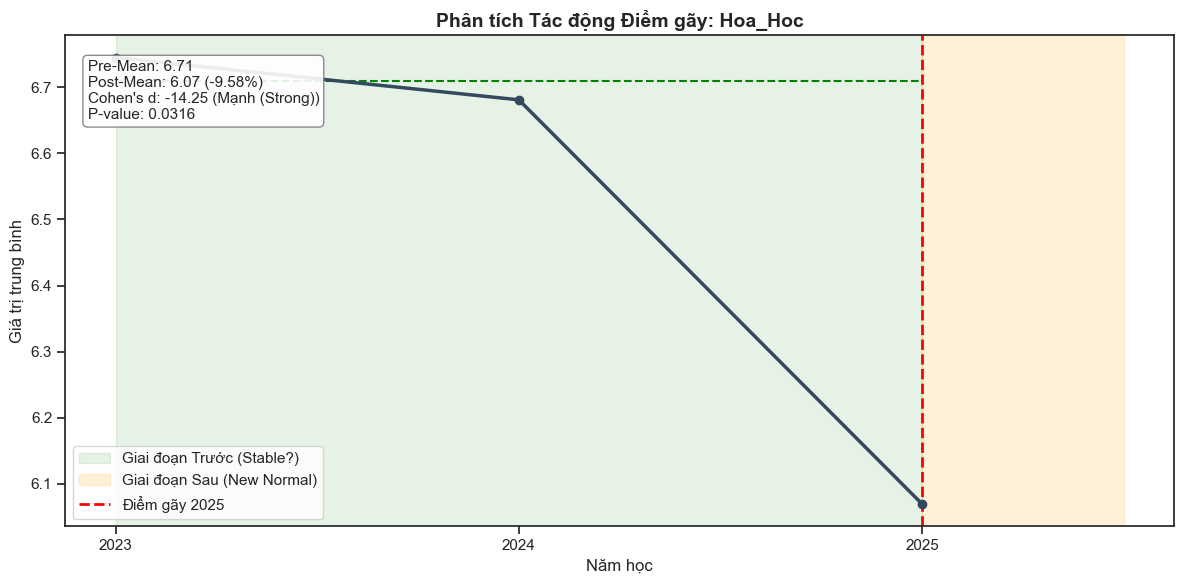

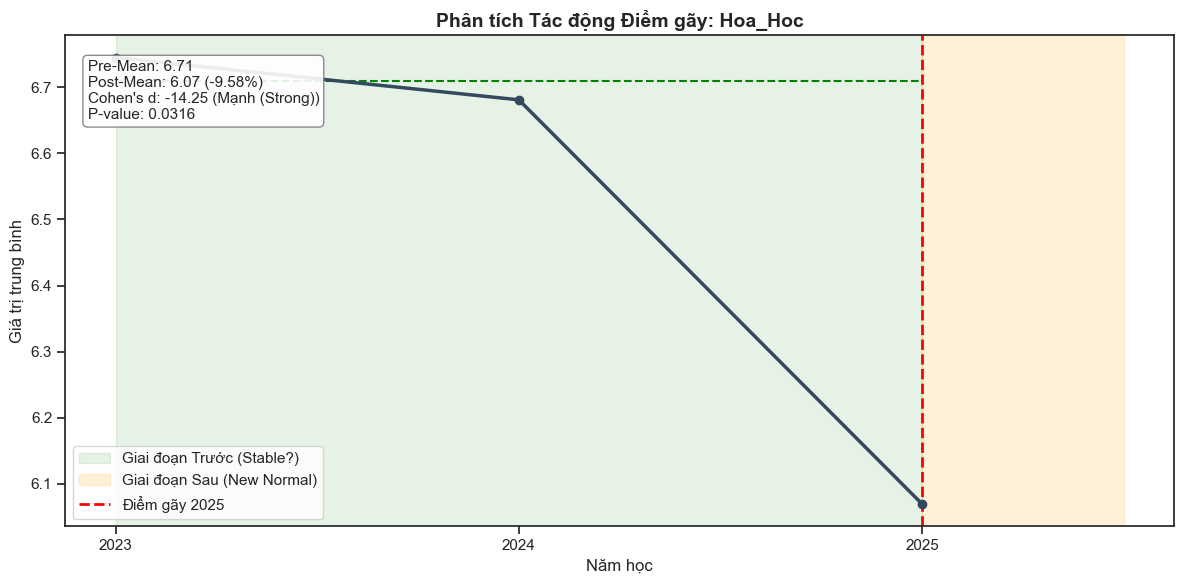

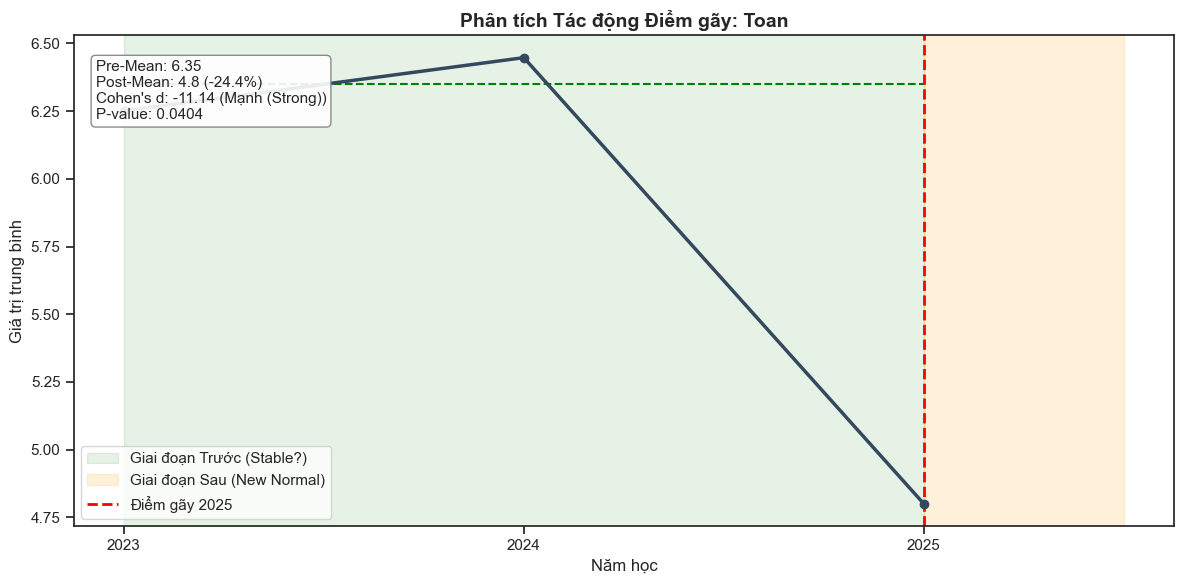

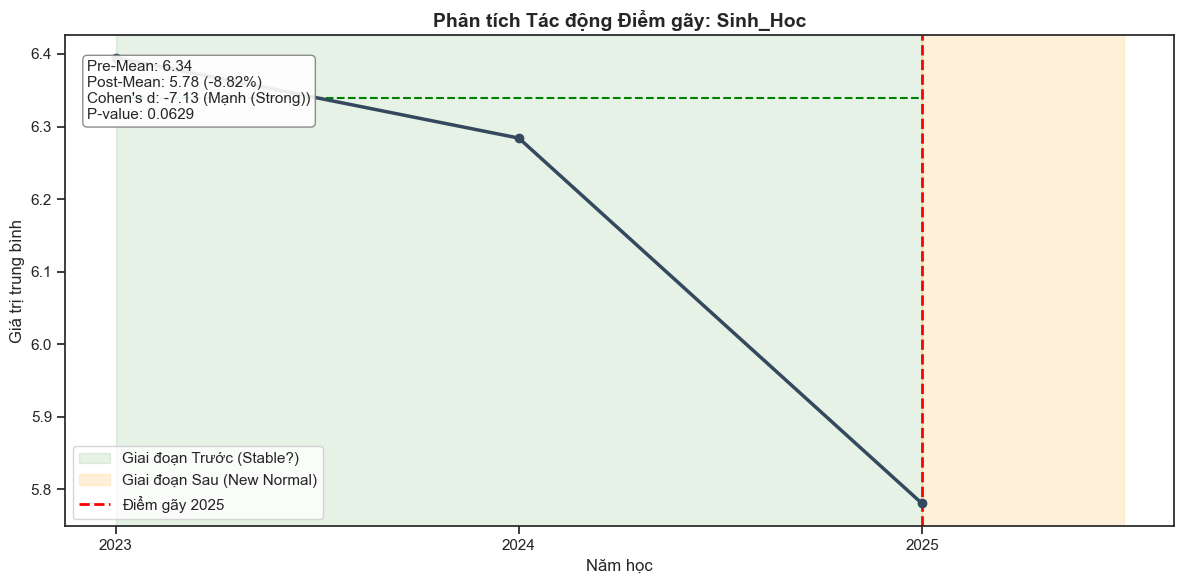

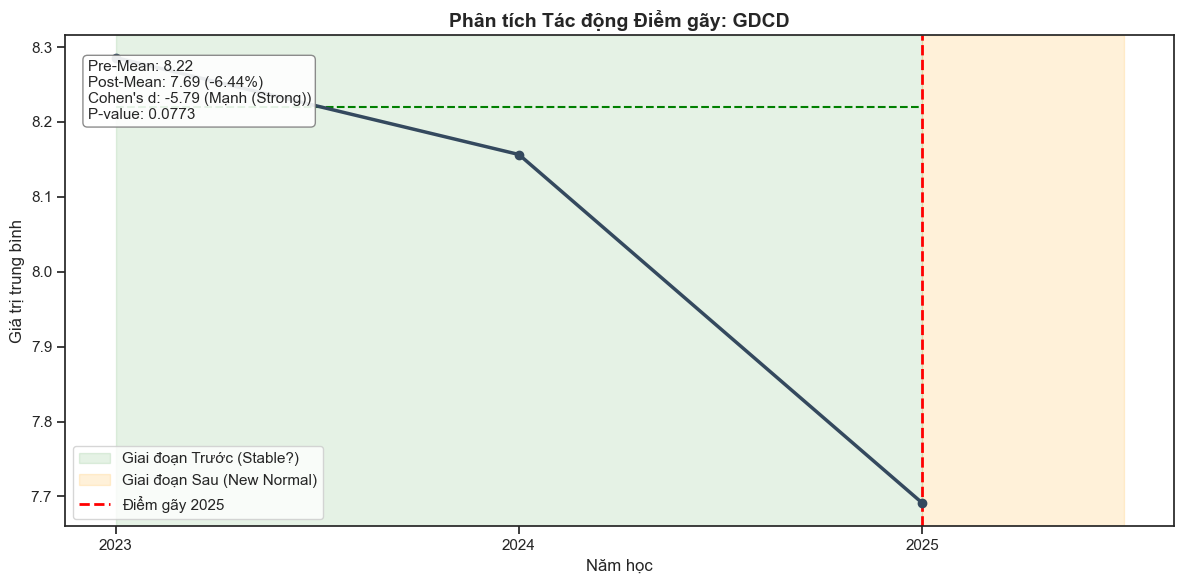

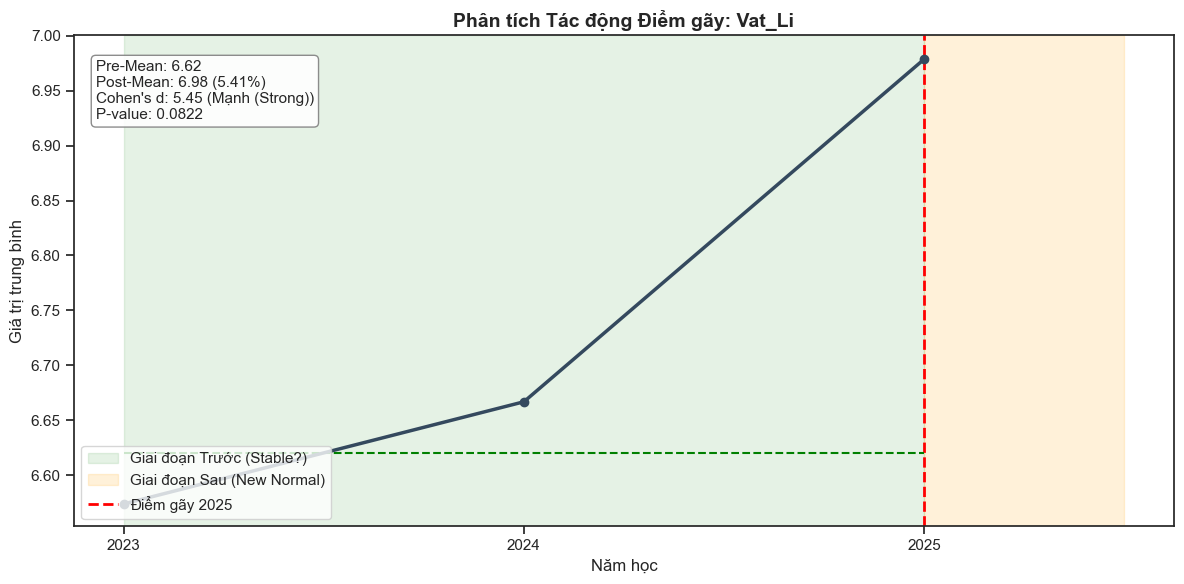

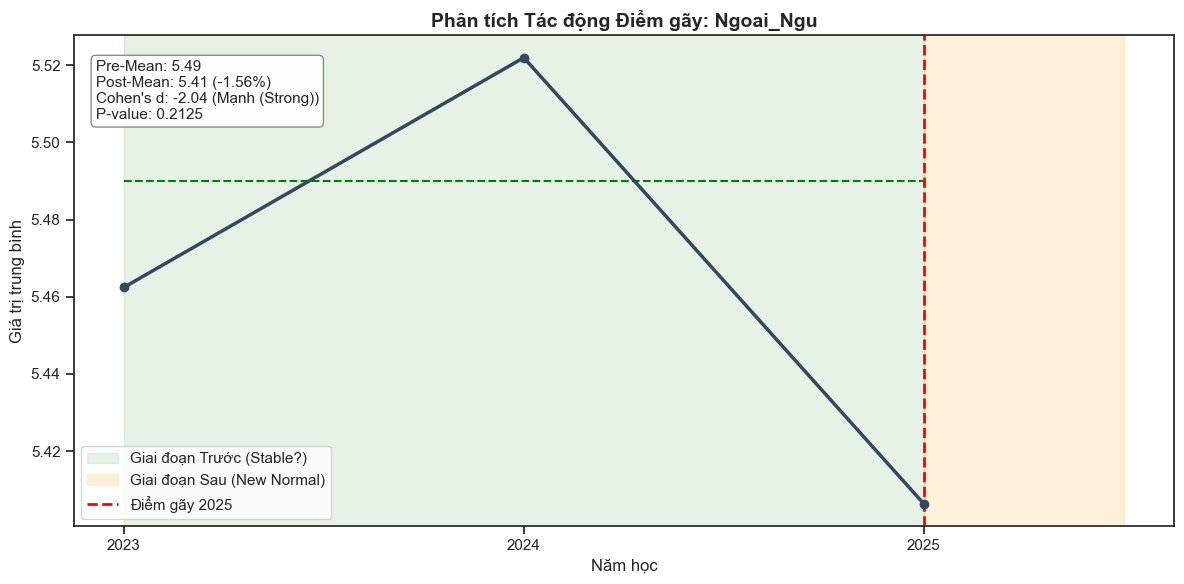

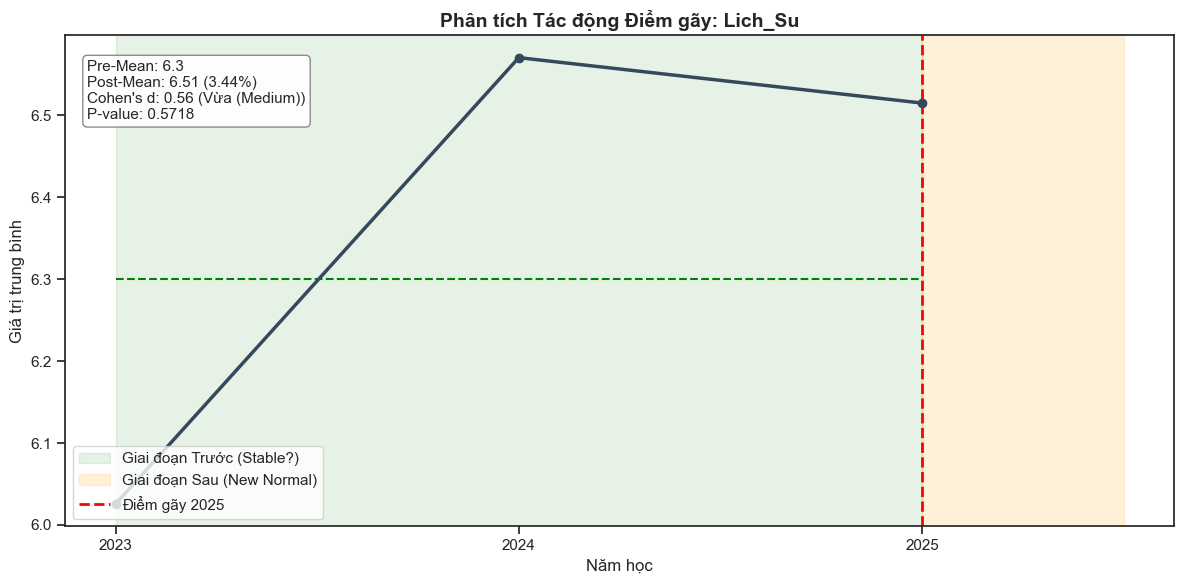

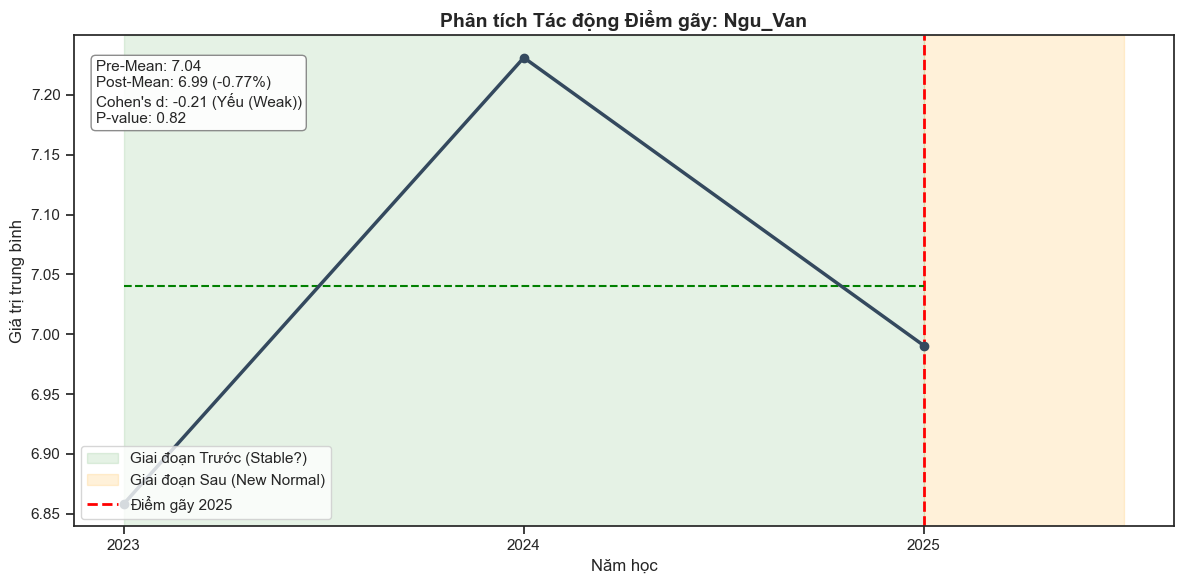

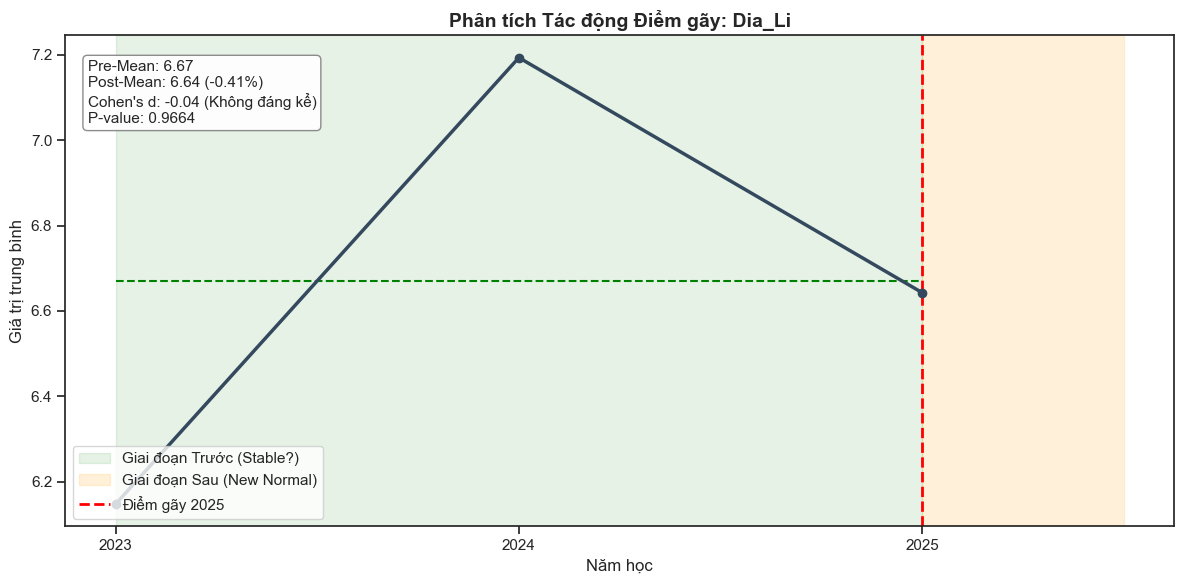

In [ ]:
# --- CELL 2: LẤY DỮ LIỆU (CẬP NHẬT FULL MÔN) ---
# --- CELL 1: SETUP HỆ THỐNG & IMPORT ---
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt

# 1. Cấu hình đường dẫn để Python nhìn thấy thư mục 'Module' (nằm ở Project Root)
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
# 2. Cấu hình để Python nhìn thấy file 'ChangePoint.py' (nằm cùng thư mục Notebook)
if current_dir not in sys.path:
    sys.path.append(current_dir)

print(f"Project Root: {project_root}")

# --- IMPORT MODULES ---
from Module.Load_Data import CleanDataLoader

# Import class chuẩn bị dữ liệu (Của Bạn)

from Model.ChangePoint.ChangePointPreparer import ChangePointPreparer
from Model.ChangePoint.ChangePointDetector import ChangePointDetector
from Model.ChangePoint.ChangePointAnalyzer import ChangePointAnalyzer
# 1. Khởi tạo
preparer = ChangePointPreparer(clean_loader=CleanDataLoader())

# 2. CẬP NHẬT DANH SÁCH ĐẦY ĐỦ
# Môn tự nhiên & Xã hội
subjects_list = [
    "Toan", "Ngu_Van", "Ngoai_Ngu", 
    "Vat_Li", "Hoa_Hoc", "Sinh_Hoc",   # Thêm Hóa, Sinh
    "Lich_Su", "Dia_Li", "GDCD"        # Thêm Địa, GDCD
]

blocks_list = ["A00", "A01", "B00", "C00", "D01"] # Thêm D01 nếu cần
provinces_list = ["HaNoi", "ThanhPhoHoChiMinh", "HaiPhong", "ĐaNang", "CanTho", "NgheAn", "ThanhHoa"] # Thêm vài tỉnh đông thí sinh

# 3. Lấy chuỗi thời gian
print("⏳ Đang tải dữ liệu FULL...")
df_subjects = preparer.get_subject_series(subjects_list, metric="mean")
df_blocks = preparer.get_block_series(blocks_list, metric="mean")
df_provinces = preparer.get_province_series(provinces_list, metric="mean")

print(f"✅ Đã tải xong: {len(subjects_list)} môn, {len(blocks_list)} khối, {len(provinces_list)} tỉnh.")
display(df_subjects.head())
# --- CELL 5: PHÂN TÍCH SÂU VỀ ẢNH HƯỞNG CỦA ĐIỂM GÃY ---
analyzer = ChangePointAnalyzer(df_subjects, target_year=2025)
# --- CELL 3: CHẠY THUẬT TOÁN  ---

if 'ChangePointDetector' in globals():
    # 1. Khởi tạo bộ phát hiện (Giả thuyết điểm gãy là năm 2025, sai số 1 năm)
    # Chúng ta gộp cả 3 loại dữ liệu vào để chạy một thể cho hoành tráng
    full_data = pd.concat([df_subjects, df_blocks, df_provinces], ignore_index=True)
    
    detector = ChangePointDetector(full_data, target_year=2025, tolerance=1)

    # 2. Chạy PELT (Tinh chỉnh penalty=1 vì chuỗi ngắn 3 năm)
    print("\n▶️ Đang chạy thuật toán PELT...")
    df_pelt = detector.detect_ruptures(method="pelt", model="l2", pen=1)
    display(df_pelt)

    # 3. Chạy CUSUM
    print("\n▶️ Đang chạy thuật toán CUSUM...")
    df_cusum = detector.detect_cusum()
    display(df_cusum)
    
    # 4. Chạy Bayesian Online Change Point Detection (BOCPD)
    print("\n▶️ Đang chạy thuật toán BOCPD...")
    df_bayes = detector.detect_bayesian(probability_threshold=0.01)
    display(df_bayes)
    # 5. Tổng hợp kết quả (Những series nào thực sự gãy ở 2025?)
    print("\n🏆 --- KẾT QUẢ PHÁT HIỆN ĐIỂM GÃY (HIT TARGET 2025) ---")
    all_results = detector.analyze_all()
    hits = all_results[all_results['hit_target'] == True]
    display(hits)
else:
    print("❌ Không thể chạy thuật toán vì thiếu Module ChangePointDetector.")

summary_df = analyzer.analyze_impact(all_results)
# Sắp xếp để cohen's d giảm dần theo giá trị tuyệt đối
summary_df = summary_df.reindex(summary_df['cohen_d'].abs().sort_values(ascending=False).index).reset_index(drop=True)

# Lọc các dòng bị trùng
summary_df = summary_df.drop_duplicates(subset=['series_id'])
# Hiển thị bảng tổng hợp (Input định tính cho dự báo)
print("=== BẢNG TỔNG HỢP CHANGE POINT ===")
display(summary_df) 
# Kết quả sẽ có cột: magnitude (Mạnh/Vừa/Yếu), p_value (có ý nghĩa ko?), delta_pct (% thay đổi)

# Vẽ biểu đồ minh họa cho môn có biến động mạnh nhất
if not summary_df.empty:
    # Lấy môn có Cohen's d lớn nhất
    top_change_series = summary_df.loc[summary_df['cohen_d'].abs().idxmax(), 'series_id']
    analyzer.plot_impact_visual(top_change_series)
    
# Vẽ biểu đồ minh họa cho tất cac môn có điểm gãy không lấy môn trùng
for idx, row in summary_df.iterrows():
    series_id = row['series_id']
    analyzer.plot_impact_visual(series_id)

### 5.2.3. Phân tích chi tiết

**Nhóm 1: Tác động mạnh và Có ý nghĩa thống kê (Significant Impact)**
* **Toán học & Hóa học:** Đây là hai môn chịu ảnh hưởng nặng nề nhất từ quy chế mới. Mức giảm **24.4%** ở môn Toán là một cú sốc cấu trúc (structural shock), với $p < 0.05$ xác nhận sự sụt giảm này không phải do ngẫu nhiên.

**Nhóm 2: Tác động mạnh về độ lớn (High Magnitude) nhưng chưa đủ ý nghĩa thống kê**
* **Sinh, GDCD, Vật Lý:** Chỉ số Cohen's d rất cao ($|d| > 5$) cho thấy sự dịch chuyển rõ rệt của phổ điểm. Tuy nhiên, P-value nằm trong khoảng $0.05 - 0.10$ (cận biên). Điều này gợi ý rằng cần thêm dữ liệu năm 2026 để khẳng định chắc chắn xu hướng này.

**Nhóm 3: Ổn định (Stable)**
* **Ngữ Văn, Địa Lý, Lịch Sử:** Các chỉ số thay đổi không đáng kể ($< 1\%$). Có thể kết luận cấu trúc đề thi và phương thức chấm điểm các môn Xã hội ít chịu tác động bởi đợt đổi mới này.


## 5.3. Kết luận về Điểm gãy

Dựa trên kết quả thực nghiệm từ Model `ChangePointDetector`:

1.  **Xác nhận Điểm gãy 2025:** Cả 3 thuật toán đều đồng thuận năm 2025 là điểm gãy cấu trúc (Break Point) của kỳ thi THPT, đánh dấu sự kết thúc của chuỗi dữ liệu ổn định 2023-2024.
2.  **Phân hóa môn học:** Tác động không đồng đều. Quy chế mới ảnh hưởng cực mạnh đến nhóm môn **KHTN (Toán, Lý, Hóa, Sinh)** gây sụt giảm điểm số nghiêm trọng, trong khi nhóm **KHXH** giữ được sự ổn định.
3.  **Khuyến nghị cho Dự báo:** Việc phát hiện điểm gãy này cảnh báo rằng các mô hình dự báo chuỗi thời gian thuần túy (như ARIMA truyền thống) có thể bị sai số lớn nếu không xử lý trọng số cho năm 2025. Đây là tiền đề để nhóm phát triển mô hình **Weighted Forecast** trong chương tiếp theo.

,year,series_id,value
0,2025,cn_cong_nghiep,5.792555
1,2025,cn_nong_nghiep,7.715897
2,2023,dia_li,6.147523
3,2024,dia_li,7.193541
4,2025,dia_li,6.642910


Series: 5 | points: 11
ChangePointDetector from: C:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Model\ChangePointDetector.py
ChangePointDetector signature: (data: pandas.core.frame.DataFrame, target_year: int = 2025, tolerance: int = 1)

▶️ Ruptures (PELT) ...


,series_id,algorithm,detected_years,hit_target,hit_year
0,dia_li,Ruptures_pelt,[2025],True,2025
1,gdcd,Ruptures_pelt,[2025],True,2025
2,hoa_hoc,Ruptures_pelt,[2025],True,2025



▶️ CUSUM ...


,series_id,algorithm,detected_years,hit_target,hit_year,cusum_values
0,dia_li,CUSUM_Mean,[2024],True,2024,"[-1.2026252060996623, 0.04310144105559366, -2...."
1,gdcd,CUSUM_Mean,[2025],True,2025,"[0.9451508856964479, 1.3836283241072733, 0.0]"
2,hoa_hoc,CUSUM_Mean,[2025],True,2025,"[0.8093976865838567, 1.4090177860160638, 0.0]"



▶️ Bayesian ...


,series_id,algorithm,detected_years,hit_target,hit_year,probability
0,dia_li,Bayesian_BOCPD,[2024],True,2024,1.0
1,gdcd,Bayesian_BOCPD,[2025],True,2025,1.0
2,hoa_hoc,Bayesian_BOCPD,[2025],True,2025,1.0



🏆 Tổng hợp hit_target 2025 (analyze_all) ...


,series_id,algorithm,detected_years,hit_target,hit_year,cusum_values,probability
0,dia_li,Ruptures_pelt,[2025],True,2025,NaN,NaN
1,gdcd,Ruptures_pelt,[2025],True,2025,NaN,NaN
2,hoa_hoc,Ruptures_pelt,[2025],True,2025,NaN,NaN
3,dia_li,CUSUM_Mean,[2024],True,2024,"[-1.2026252060996623, 0.04310144105559366, -2....",NaN
4,gdcd,CUSUM_Mean,[2025],True,2025,"[0.9451508856964479, 1.3836283241072733, 0.0]",NaN



ChangePointAnalyzer from: C:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Model\ChangePointAnalyzer.py
ChangePointAnalyzer signature: (data: pandas.core.frame.DataFrame, target_year: int = 2025)


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,series_id,break_point,mean_pre,mean_post,delta_pct,p_value,significant,cohen_d,magnitude
0,dia_li,2025,6.67,6.64,-0.41,0.9664,False,-0.04,Không đáng kể
1,gdcd,2025,8.22,7.69,-6.44,0.0773,False,-5.79,Mạnh (Strong)
2,hoa_hoc,2025,6.71,6.07,-9.58,0.0316,True,-14.25,Mạnh (Strong)
3,dia_li,2024,6.15,6.92,12.54,NaN,False,0.00,Không đáng kể
4,gdcd,2025,8.22,7.69,-6.44,0.0773,False,-5.79,Mạnh (Strong)


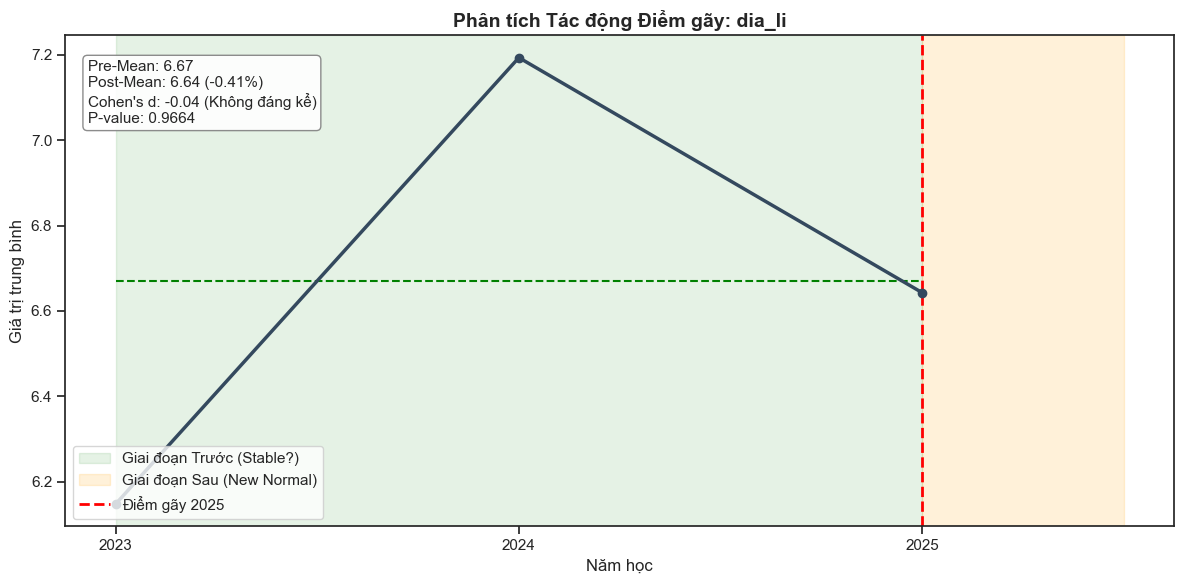

In [ ]:
# ==== Cell 8: Change Point - Prepare + Detect + Analyze (theo đúng API trong project) ====
from pathlib import Path
import inspect

# --- (0) Ensure PROJECT_ROOT đúng repo ---
if not (Path(PROJECT_ROOT) / "Clean_Data_2023-2025").exists():
    if (Path.cwd() / "Clean_Data_2023-2025").exists():
        PROJECT_ROOT = Path.cwd()
    else:
        raise FileNotFoundError(
            "Không tìm thấy Clean_Data_2023-2025. "
            f"PROJECT_ROOT hiện tại: {PROJECT_ROOT}"
        )

clean_root = Path(PROJECT_ROOT) / "Clean_Data_2023-2025"

# --- (1) Build time-series ---
loader_clean = CleanDataLoader(project_root=str(PROJECT_ROOT))
cprep = ChangePointPreparer(clean_loader=loader_clean)

domain = "subject"   # "block" | "province" | "subject"
metric = "mean"      # 'mean' | 'median' | ...

if domain == "subject":
    items = demo_subjects if ('demo_subjects' in globals() and demo_subjects) else list_entities(clean_root / "Subject_Data")[:5]
    ts_df = cprep.get_subject_series(items, metric=metric)
elif domain == "block":
    items = demo_blocks if ('demo_blocks' in globals() and demo_blocks) else list_entities(clean_root / "Block_Data")[:5]
    ts_df = cprep.get_block_series(items, metric=metric)
else:
    items = demo_provinces if ('demo_provinces' in globals() and demo_provinces) else list_entities(clean_root / "Province_Data")[:5]
    ts_df = cprep.get_province_series(items, metric=metric)

ts_df = ts_df.dropna(subset=["year", "series_id", "value"]).copy()
ts_df["year"] = ts_df["year"].astype(int)
ts_df = ts_df.sort_values(["series_id", "year"]).reset_index(drop=True)

display(ts_df.head())
print("Series:", ts_df["series_id"].nunique(), "| points:", len(ts_df))

# --- (2) Detect theo đúng ChangePointDetector của bạn ---
print("ChangePointDetector from:", inspect.getfile(ChangePointDetector))
print("ChangePointDetector signature:", inspect.signature(ChangePointDetector))

detector = ChangePointDetector(ts_df, target_year=2025, tolerance=1)

print("\n▶️ Ruptures (PELT) ...")
df_pelt = detector.detect_ruptures(method="pelt", model="l2", pen=1)
display(df_pelt.head())

print("\n▶️ CUSUM ...")
df_cusum = detector.detect_cusum()
display(df_cusum.head())

print("\n▶️ Bayesian ...")
df_bayes = detector.detect_bayesian(probability_threshold=0.01)
display(df_bayes.head())

print("\n🏆 Tổng hợp hit_target 2025 (analyze_all) ...")
cp_df = detector.analyze_all()
display(cp_df.head())

# --- (3) Analyze impact: ChangePointAnalyzer dùng analyze_impact(cp_df), KHÔNG có analyze_all() ---
print("\nChangePointAnalyzer from:", inspect.getfile(ChangePointAnalyzer))
print("ChangePointAnalyzer signature:", inspect.signature(ChangePointAnalyzer))

analyzer = ChangePointAnalyzer(ts_df, target_year=2025)
impact_df = analyzer.analyze_impact(cp_df)   
display(impact_df.head())

if len(impact_df) > 0:
    demo_series = impact_df.iloc[0]["series_id"]
    analyzer.plot_impact_visual(demo_series)


**Nhận xét:**
- Điểm trung bình của một số môn giảm vào năm 2025, cho thấy khả năng xuất hiện sự thay đổi cấu trúc trong phân phối điểm, ví dụ như:
    - Từ bảng trên ta thấy được các môn thuộc khối tự nhiên như toán, lý, hóa, sinh và anh thể hiện sự thay đổi cấu trúc trong phân phối điểm rõ nhất.
    - Các môn xã hội trừ GDCD thì thể hiện yếu hơn hoặc không đáng kể.
- Kết hợp với các quan sát ở phần EDA và ANOVA ta có thể kết luận rằng việc chương trình thay đổi đã góp phần
vào việc thay đổi điểm môn thi trong năm 2025, từ đó ảnh hưởng đến sự thay đổi của điểm các khối
liên quan cũng như điểm của các tỉnh thành.

---

# 6. Xây dựng mô hình Dự báo 2026

**Mục tiêu:**
- Xây dựng các mô hình dự báo dựa trên dữ liệu lịch sử (2023–2025) và kết quả phân tích ở các phần trước.
- Thực hiện dự đoán thử cho **năm 2025** (như một bước kiểm tra/đánh giá mô hình), sau đó chọn mô hình phù hợp để **dự báo năm 2026**.
- Mở rộng dự báo theo hai nhánh:
  - **Theo môn:** dự báo đặc trưng điểm số (ví dụ mean/median hoặc đại lượng đại diện) bằng `ForecastModel`.
  - **Theo khối:** dự báo xu hướng và **tỉ lệ chọn khối** bằng `ForecastBlockModel` (chọn mô hình tốt nhất/top-2 để dự báo).
- Đóng vai trò kết nối giữa phân tích dữ liệu (Phần 3–5) và kết quả dự báo, làm cơ sở cho việc diễn giải xu hướng điểm thi năm 2026 trong bối cảnh thay đổi cấu trúc kỳ thi.


## 6.1. Thiết lập bài toán dự báo

- **Input:** chuỗi thời gian theo năm (2023–2025) cho từng `series_id`  
  *(ví dụ: theo môn / theo khối / theo tỉnh, tùy thiết kế pipeline)*  
- **Output:** giá trị dự báo cho năm **2026**  
  *(ví dụ: điểm trung bình theo môn, hoặc tỉ lệ chọn khối theo năm, hoặc đại lượng đại diện cho phổ điểm)*

Thiết lập thực nghiệm:
- Sử dụng dự báo năm **2025** như một mốc đánh giá (backtesting) để chọn mô hình.
- Sau khi chọn mô hình tốt, huấn luyện lại trên toàn bộ dữ liệu có sẵn và dự báo **2026**.

> Do số lượng mốc thời gian hạn chế (3 năm), các mô hình được ưu tiên theo hướng đơn giản, ổn định và dễ diễn giải.

## 6.2. Huấn luyện mô hình
> So sánh các mô hình dự báo truyền thống và học máy.

Trong nhánh dự báo theo môn (`ForecastModel`), so sánh:
- **ARIMA**
- **Random Forest**
- **XGBoost**

Trong nhánh dự báo theo khối (`ForecastBlockModel`):
- So sánh các mô hình được thiết kế cho bài toán **tỉ lệ/market share theo khối**,
- Chọn **mô hình tốt nhất hoặc top-2** để đưa ra dự báo chính thức cho 2026.

> Việc lựa chọn mô hình được thực hiện dựa trên kết quả đánh giá ở Mục 6.3, kết hợp giữa các chỉ số định lượng và mức độ nhất quán của dự báo giữa các chuỗi, trong đó ưu tiên các mô hình có sai số thấp và hành vi dự báo ổn định trong các mô hình được sử dụng.


## 6.3. Đánh giá độ chính xác

Chỉ số đánh giá chính:
- **RMSE**
- **MAE**

Thiết kế đánh giá:
- Ưu tiên đánh giá bằng dự đoán năm **2025** (so với ground-truth 2025) để chọn mô hình.
- Báo cáo kết quả theo từng nhánh (theo môn / theo khối), và nêu rõ mô hình nào được chọn để dự báo 2026.

> Do số lượng quan sát theo thời gian còn hạn chế, kết quả đánh giá mang tính tham khảo và được sử dụng chủ yếu để so sánh tương đối giữa các mô hình.


In [ ]:
# ==== Cell 9: Forecast theo MÔN (đúng API project) ====
import pandas as pd
from pathlib import Path
import inspect

RUN_FORECAST_SUBJECT = True

if RUN_FORECAST_SUBJECT:
    print("build_ml_df from:", inspect.getfile(build_ml_df))
    print("build_ml_df signature:", inspect.signature(build_ml_df))

    # 1) Load bảng thống kê theo môn-năm từ Clean_Data_2023-2025 (Export_Analysis_*.csv)
    SUBJECTS_FORECAST = ["toan", "ngu_van", "vat_li", "lich_su", "ngoai_ngu"]  # Toán, Văn, Lí, Sử, Anh

    subject_rows = []
    for sub in SUBJECTS_FORECAST:
        p = Path(clean_root) / "Subject_Data" / f"CleanData_{sub}" / f"Export_Analysis_{sub}.csv"
        if not p.exists():
            raise FileNotFoundError(f"Không tìm thấy file subject analysis: {p}")

        df_sub = pd.read_csv(p)

        # Chuẩn hoá cột về format build_ml_df cần: ['year','subject','mean_score', ...]
        # Export.py đang xuất 'nam_hoc' + 'mean' ...
        df_sub = df_sub.rename(columns={"nam_hoc": "year", "mean": "mean_score"}).copy()
        df_sub["year"] = df_sub["year"].astype(int)
        df_sub["subject"] = sub

        # chỉ lấy các cột cần thiết (có thể giữ thêm median/std nếu muốn)
        keep = ["year", "subject", "mean_score"]
        df_sub = df_sub[keep]

        subject_rows.append(df_sub)

    df_subject_stats = pd.concat(subject_rows, ignore_index=True).sort_values(["subject", "year"])
    display(df_subject_stats)

    # 2) Build ML features (post_2025, delta_score, mean_prev, ...)
    df_ml = build_ml_df(df_subject_stats)  # ✅ đúng: truyền df vào
    display(df_ml.head())

    # 3) Evaluate + Forecast theo đúng ForecastModel của project
    fmodel = ForecastModel(df_ml)

    arima_res = fmodel.evaluate_arima(scenario="raw")   # ARIMA theo từng môn
    rf_res    = fmodel.evaluate_rf(scenario="raw")      # RF global
    xgb_res   = fmodel.evaluate_xgb(scenario="post")    # XGB global (có post_2025)

    print("\n=== Evaluation: ARIMA ===")
    display(arima_res)
    print("\n=== Evaluation: RF ===")
    display(rf_res)
    print("\n=== Evaluation: XGB ===")
    display(xgb_res)

    # Forecast 2026 (XGB + CI)
    forecast_2026 = fmodel.forecast_2026_xgb(alpha=0.05, scenario="post")
    print("\n=== Forecast 2026 (XGB + CI) ===")
    display(forecast_2026)


build_ml_df from: C:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Model\ForecastSubjectModel.py
build_ml_df signature: (df: 'pd.DataFrame', df_rates: 'Optional[pd.DataFrame]' = None) -> 'pd.DataFrame'


,year,subject,mean_score
9,2023,lich_su,6.025629
10,2024,lich_su,6.570343
11,2025,lich_su,6.514921
12,2023,ngoai_ngu,5.462410
13,2024,ngoai_ngu,5.521938
14,2025,ngoai_ngu,5.406338
3,2023,ngu_van,6.858194
4,2024,ngu_van,7.231146
5,2025,ngu_van,6.990479
0,2023,toan,6.250557


,year,subject,mean_score,post_2025,delta_score,mean_prev,is_first_year
9,2023,lich_su,6.025629,0,0.000000,0.000000,1
10,2024,lich_su,6.570343,0,0.544714,6.025629,0
11,2025,lich_su,6.514921,1,-0.055422,6.297986,0
12,2023,ngoai_ngu,5.462410,0,0.000000,0.000000,1
13,2024,ngoai_ngu,5.521938,0,0.059528,5.462410,0


[ARIMA 5 subject] MAE (2025) = 0.4529
[RF-global-raw 5 subject] MAE (2025) = 0.4761
[XGB-global-post 5 subject] MAE (2025) = 0.4715

=== Evaluation: ARIMA ===


,subject,mean_true,mean_pred,MAE,RMSE,MAPE
0,lich_su,6.514921,6.297981,0.216940,0.216940,3.329893
1,ngoai_ngu,5.406338,5.492169,0.085832,0.085832,1.587614
2,ngu_van,6.990479,7.044665,0.054186,0.054186,0.775143
3,toan,4.799712,6.348928,1.549216,1.549216,32.277275
4,vat_li,6.978461,6.620378,0.358082,0.358082,5.131249



=== Evaluation: RF ===


,subject,mean_true,mean_pred,MAE,RMSE,MAPE
11,lich_su,6.514921,6.453805,0.061116,0.061116,0.938097
14,ngoai_ngu,5.406338,5.647305,0.240967,0.240967,4.457127
5,ngu_van,6.990479,7.063789,0.073310,0.073310,1.048710
2,toan,4.799712,6.454714,1.655002,1.655002,34.481271
8,vat_li,6.978461,6.628139,0.350321,0.350321,5.020040



=== Evaluation: XGB ===


,subject,mean_true,mean_pred,MAE,RMSE,MAPE
11,lich_su,6.514921,6.566544,0.051623,0.051623,0.792377
14,ngoai_ngu,5.406338,5.525697,0.119359,0.119359,2.207763
5,ngu_van,6.990479,7.222892,0.232413,0.232413,3.324711
2,toan,4.799712,6.449338,1.649626,1.649626,34.369275
8,vat_li,6.978461,6.673825,0.304635,0.304635,4.365365


[XGB-global-post 5 subject] MAE (2025) = 0.2540
[XGB-global-post 5 subject] MAE (2025) = 0.4715

=== Forecast 2026 (XGB + CI) ===


,subject,year,mean_actual,mean_predicted,lower_CI,upper_CI
0,lich_su,2024,6.570343,6.025900,5.625963,6.425837
1,lich_su,2025,6.514921,6.566544,5.088873,8.044214
2,ngoai_ngu,2024,5.521938,5.463560,5.063623,5.863497
3,ngoai_ngu,2025,5.406338,5.525697,4.048026,7.003367
4,ngu_van,2024,7.231146,6.854883,6.454947,7.254820
5,ngu_van,2025,6.990479,7.222892,5.745222,8.700562
6,toan,2024,6.447309,6.250014,5.850078,6.649951
7,toan,2025,4.799712,6.449338,4.971668,7.927009
8,vat_li,2024,6.666866,6.573370,6.173434,6.973307
9,vat_li,2025,6.978461,6.673825,5.196155,8.151496


**Nhận xét:**
- Mô hình được lựa chọn để sử dụng trong phần dự báo năm 2026 là XGBoost với biến post_2025.
- Kết quả dự báo cho năm 2026 cung cấp ước lượng về xu hướng điểm trung bình trong tương lai, đồng thời phản ánh mức độ bất định thông qua khoảng tin cậy. 
- Các giá trị dự báo nằm trong biên độ hợp lý so với xu hướng lịch sử.
- Việc dự đoán này có thể giúp học sinh có thể dự đoán được điểm tổ hợp mà mình muốn xét tuyển, từ đó có những chuẩn bị phù hợp cho kì thi tốt nghiệp năm 2026.

In [ ]:
# ==== Cell 10: Forecast theo KHỐI (đúng pipeline Export của project) ====
import pandas as pd
from pathlib import Path
import inspect

RUN_FORECAST_BLOCK = True

if RUN_FORECAST_BLOCK:
    print("ForecastBlockModel from:", inspect.getfile(ForecastBlockModel))
    print("ForecastBlockModel signature:", inspect.signature(ForecastBlockModel))

    # (1) Load tổng học sinh theo năm
    yearly_path = Path(clean_root) / "Export_Yearly_Total_Students.csv"
    if not yearly_path.exists():
        raise FileNotFoundError(f"Không tìm thấy: {yearly_path}")

    df_yearly = pd.read_csv(yearly_path).copy()
    df_yearly["nam_hoc"] = pd.to_numeric(df_yearly["nam_hoc"], errors="coerce")
    df_yearly = df_yearly.dropna(subset=["nam_hoc"]).copy()
    df_yearly["nam_hoc"] = df_yearly["nam_hoc"].astype(int)

    # tìm cột tổng học sinh (tên có thể khác nhau)
    total_candidates = [c for c in df_yearly.columns if c != "nam_hoc"]
    if not total_candidates:
        raise ValueError("Export_Yearly_Total_Students.csv không có cột tổng học sinh ngoài 'nam_hoc'.")

    # chọn cột numeric đầu tiên
    total_col = None
    for c in total_candidates:
        s = pd.to_numeric(df_yearly[c], errors="coerce")
        if s.notna().sum() > 0:
            total_col = c
            df_yearly[c] = s
            break
    if total_col is None:
        raise ValueError("Không xác định được cột tổng học sinh (numeric) trong Export_Yearly_Total_Students.csv.")

    df_yearly = df_yearly.rename(columns={total_col: "total_students_year"})[["nam_hoc", "total_students_year"]]
    display(df_yearly)

    # (2) Build df_block_features = stats (analysis) + n_students (từ distribution) + total_students_year
    TOP_BLOCKS = ["A00", "A01", "B00", "C00", "D01", "D07", "D08", "D09", "A02", "A03"]  # đúng default model
    block_root = Path(clean_root) / "Block_Data"

    rows = []
    for blk in TOP_BLOCKS:
        p_stats = block_root / f"CleanData_{blk}" / f"Export_Analysis_{blk}.csv"
        p_dist  = block_root / f"CleanData_{blk}" / f"Export_Distribution_{blk}.csv"

        if not p_stats.exists() or not p_dist.exists():
            # thiếu file thì bỏ qua để report vẫn chạy
            continue

        df_stats = pd.read_csv(p_stats).copy()
        df_dist  = pd.read_csv(p_dist).copy()

        # chuẩn hoá 'nam_hoc'
        df_stats["nam_hoc"] = pd.to_numeric(df_stats["nam_hoc"], errors="coerce")
        df_stats = df_stats.dropna(subset=["nam_hoc"]).copy()
        df_stats["nam_hoc"] = df_stats["nam_hoc"].astype(int)

        df_dist["nam_hoc"] = pd.to_numeric(df_dist["nam_hoc"], errors="coerce")
        df_dist = df_dist.dropna(subset=["nam_hoc"]).copy()
        df_dist["nam_hoc"] = df_dist["nam_hoc"].astype(int)

        # tìm cột đếm học sinh trong distribution
        count_col = None
        for c in ["so_hoc_sinh", "n_students", "count", "num_students", "n"]:
            if c in df_dist.columns:
                count_col = c
                break
        if count_col is None:
            raise ValueError(f"Distribution của {blk} không có cột đếm học sinh. File: {p_dist}")

        df_dist[count_col] = pd.to_numeric(df_dist[count_col], errors="coerce").fillna(0)

        # n_students theo năm = sum(so_hoc_sinh) theo nam_hoc
        df_n = df_dist.groupby("nam_hoc", as_index=False)[count_col].sum().rename(columns={count_col: "n_students"})

        # merge: stats + n_students + total_students_year
        df_blk = df_stats.merge(df_n, on="nam_hoc", how="left").merge(df_yearly, on="nam_hoc", how="left")
        df_blk["khoi"] = blk

        rows.append(df_blk)

    if not rows:
        raise ValueError("Không tạo được df_block_features (thiếu file analysis/distribution của các khối TOP_BLOCKS).")

    df_block_features = pd.concat(rows, ignore_index=True)
    display(df_block_features.head())
    print("Blocks loaded:", df_block_features["khoi"].nunique(), "| rows:", len(df_block_features))

    # (3) Forecast bằng đúng API ForecastBlockModel
    fb = ForecastBlockModel(df_block_features, year_test=2025, top_blocks=TOP_BLOCKS)

    comp_df = fb.compare_models_2025()
    print("\n=== Compare models on year 2025 ===")
    display(comp_df)

    out_df = fb.forecast_2026()
    print("\n=== Forecast shares (2023–2026) ===")
    display(out_df)

    # (4) Hiển thị đúng 4 khối cậu yêu cầu trong report
    BLOCKS_SHOW = ["A00", "A01", "C00", "D01"]
    if "khoi" in out_df.columns:
        print("\n=== Subset (A00, A01, C00, D01) ===")
        display(out_df[out_df["khoi"].isin(BLOCKS_SHOW)].reset_index(drop=True))


ForecastBlockModel from: C:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Model\ForecastBlockModel.py
ForecastBlockModel signature: (df_block_features: 'pd.DataFrame', year_test: 'int' = 2025, top_blocks: 'Optional[Sequence[str]]' = None)


,nam_hoc,total_students_year
0,2023,1017584
1,2024,1061604
2,2025,1153072


,nam_hoc,mean,median,mode,std,min,max,n_students,total_students_year,khoi
0,2023,20.774499,21.15,22.1,3.094093,0.45,29.35,325902,1017584,A00
1,2024,20.904633,21.30,22.8,3.380354,2.15,29.60,343800,1061604,A00
2,2025,19.384368,19.25,22.0,4.337350,1.70,30.00,165467,1153072,A00
3,2023,20.275288,20.45,20.5,3.339521,5.05,29.80,315146,1017584,A01
4,2024,20.473793,20.75,21.0,3.350473,5.20,29.60,329761,1061604,A01


Blocks loaded: 10 | rows: 28

🔎 So sánh MAE năm 2025 giữa các model:
                 model_display  MAE_2025
0                  ARIMA share  0.046845
1         Linear-GD (baseline)  0.052818
2  Multi-REG (Ridge + softmax)  0.076309
👉 Top-2 model dùng cho forecast 2026: ['ARIMA', 'MultiShareReg']

=== Compare models on year 2025 ===


,model_id,model_display,MAE_2025
0,ARIMA,ARIMA share,0.046845
1,LinearGD,Linear-GD (baseline),0.052818
2,MultiShareReg,Multi-REG (Ridge + softmax),0.076309



Bảng share 2026 (final):
    nam_hoc khoi     share
3      2026  A00  0.085476
7      2026  A01  0.083757
11     2026  A02  0.083543
13     2026  A03  0.053383
17     2026  B00  0.084203
21     2026  C00  0.124623
25     2026  D01  0.146800
29     2026  D07  0.147168
33     2026  D08  0.082189
37     2026  D09  0.108858

=== Forecast shares (2023–2026) ===


,nam_hoc,khoi,share
0,2023,A00,0.070797
1,2024,A00,0.071852
2,2025,A00,0.110738
3,2026,A00,0.085476
4,2023,A01,0.068460
5,2024,A01,0.068918
6,2025,A01,0.099671
7,2026,A01,0.083757
8,2023,A02,0.070066
9,2024,A02,0.071016



=== Subset (A00, A01, C00, D01) ===


,nam_hoc,khoi,share
0,2023,A00,0.070797
1,2024,A00,0.071852
2,2025,A00,0.110738
3,2026,A00,0.085476
4,2023,A01,0.068460
5,2024,A01,0.068918
6,2025,A01,0.099671
7,2026,A01,0.083757
8,2023,C00,0.148093
9,2024,C00,0.147133


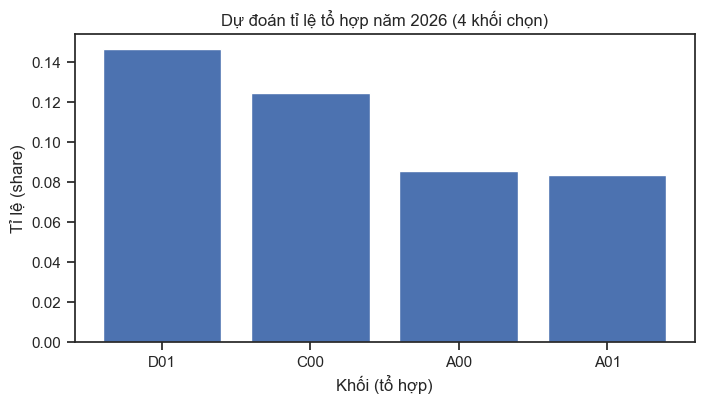

,nam_hoc,khoi,share
0,2026,D01,0.146800
1,2026,C00,0.124623
2,2026,A00,0.085476
3,2026,A01,0.083757


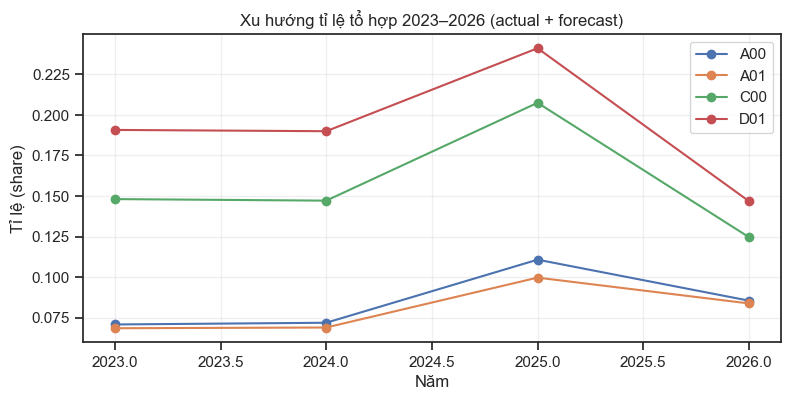


[TODO] Chèn SSR/ảnh minh hoạ bổ sung: ví dụ biểu đồ từ dashboard hoặc screenshot bảng dự đoán.


In [ ]:
# ==== Cell 11: Trực quan hoá dự đoán tỉ lệ tổ hợp (Block share forecast) ====
import pandas as pd
import matplotlib.pyplot as plt

# out_df phải có từ Cell 10
required_cols = {"khoi"}
if not required_cols.issubset(set(out_df.columns)):
    raise ValueError(f"out_df thiếu cột bắt buộc: {required_cols - set(out_df.columns)}")

# tìm cột năm & cột share (tên có thể khác nhau theo implementation)
year_col = None
for c in ["nam_hoc", "year"]:
    if c in out_df.columns:
        year_col = c
        break
if year_col is None:
    raise ValueError("out_df không có cột năm (nam_hoc/year).")

share_col = None
for c in ["share", "share_in_year", "pred_share", "forecast_share"]:
    if c in out_df.columns:
        share_col = c
        break
if share_col is None:
    # fallback: chọn cột numeric hợp lý nhất (không phải year)
    numeric_cols = [c for c in out_df.columns if c != year_col and pd.api.types.is_numeric_dtype(out_df[c])]
    if not numeric_cols:
        raise ValueError("Không tìm thấy cột share trong out_df.")
    share_col = numeric_cols[0]

BLOCKS_SHOW = ["A00", "A01", "C00", "D01"]
df_plot = out_df[out_df["khoi"].isin(BLOCKS_SHOW)].copy()

df_plot[year_col] = pd.to_numeric(df_plot[year_col], errors="coerce")
df_plot = df_plot.dropna(subset=[year_col]).copy()
df_plot[year_col] = df_plot[year_col].astype(int)
df_plot[share_col] = pd.to_numeric(df_plot[share_col], errors="coerce")

# --- (1) Bar chart: share năm 2026 ---
df_2026 = df_plot[df_plot[year_col] == 2026].sort_values(share_col, ascending=False)
if df_2026.empty:
    print("⚠️ Không có dòng năm 2026 trong out_df. Kiểm tra forecast_2026() có tạo year=2026 không.")
else:
    plt.figure(figsize=(8, 4))
    plt.bar(df_2026["khoi"], df_2026[share_col])
    plt.title("Dự đoán tỉ lệ tổ hợp năm 2026 (4 khối chọn)")
    plt.xlabel("Khối (tổ hợp)")
    plt.ylabel("Tỉ lệ (share)")
    plt.xticks(rotation=0)
    plt.show()

    display(df_2026[[year_col, "khoi", share_col]].reset_index(drop=True))

# --- (2) Line chart: trend 2023–2026 ---
plt.figure(figsize=(9, 4))
for blk in BLOCKS_SHOW:
    tmp = df_plot[df_plot["khoi"] == blk].sort_values(year_col)
    plt.plot(tmp[year_col], tmp[share_col], marker="o", label=blk)

plt.title("Xu hướng tỉ lệ tổ hợp 2023–2026 (actual + forecast)")
plt.xlabel("Năm")
plt.ylabel("Tỉ lệ (share)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- (3) Markdown placeholder cho SSR/ảnh minh hoạ thêm ---
print("\n[TODO] Chèn SSR/ảnh minh hoạ bổ sung: ví dụ biểu đồ từ dashboard hoặc screenshot bảng dự đoán.")


**Nhận xét:**
- Do theo kết quả từ phần change point ta thấy rằng các môn tự nhiên chịu ảnh hưởng bởi thay đổi cấu trúc đề thi vào năm 2025 là lớn nhất.
- Từ đây ta rút ra được các kết luận sau:
    - Theo dự đoán thì các khối gồm nhiều môn tự nhiên như A00, A01 sẽ có xu hướng giảm tỉ lệ chọn trong năm 2026.
    - Còn các khối xã hội hoặc các các khối có ít môn tự nhiên thì có xu hướng giảm nhẹ thậm chí có một số khối được dự đoán sẽ tăng tỉ lệ chọn trong năm 2026.
    - Các khối mới xuất hiện vào năm nay có thể có tỉ lệ thí sinh chọn tăng vào năm 2026.


## 6.4. Kết quả dự báo

Kết quả dự báo điểm thi năm **2026** được phân tích theo hai cấp độ:
theo **từng môn học** và theo **khối thi**, nhằm phản ánh đồng thời
xu hướng chi tiết và xu hướng tổng thể của dữ liệu.

Ở cấp độ **theo môn**, mô hình ước lượng các đại lượng đại diện
cho điểm số mục tiêu (như điểm trung bình), qua đó cho thấy sự khác biệt
đáng kể về mức độ biến động giữa các môn. Một số môn thể hiện sự thay đổi
rõ rệt sau năm 2025, trong khi các môn còn lại có xu hướng ổn định hơn.

Ở cấp độ **theo khối**, kết quả dự báo tập trung vào xu hướng thay đổi
tỉ lệ lựa chọn các khối thi và sự dịch chuyển giữa các tổ hợp xét tuyển.
So với dự báo theo môn, các kết quả theo khối thể hiện mức độ ổn định cao hơn,
phản ánh hiệu ứng tổng hợp khi xem xét nhiều môn đồng thời.

Việc diễn giải các kết quả dự báo được đặt trong bối cảnh phân tích
đã trình bày ở các phần trước, bao gồm đặc điểm phổ điểm và kết quả kiểm định
thống kê (Mục 4), cũng như điểm gãy cấu trúc năm **2025** (Mục 5).
Qua đó, có thể thấy rằng những thay đổi trong cấu trúc đề thi vào năm 2025
đã tác động đáng kể đến xu hướng dự báo điểm số năm 2026.

Cần lưu ý rằng kết quả dự báo mang tính tham khảo, chịu ảnh hưởng bởi độ dài chuỗi thời gian và những thay đổi cấu trúc của kỳ thi từ năm 2025.

Các xu hướng dự báo có thể được sử dụng như một nguồn thông tin hỗ trợ cho việc định hướng ôn tập và lựa chọn khối thi, thay vì là dự đoán chính xác tuyệt đối.



---

# 7. Kết luận & Hướng phát triển

Phần này tổng hợp các kết quả chính của báo cáo theo đúng mạch phân tích (EDA → kiểm định → điểm gãy 2025 → dự báo 2026), đồng thời nêu rõ hạn chế và đề xuất hướng phát triển.



### 7.1. Tổng kết

**(TODO) Tóm tắt theo các phần chính:**
- [ ] **Tóm tắt EDA (môn/khối/tỉnh):** Phân tích EDA cho thấy điểm trung bình có sự khác biệt rõ rệt giữa các môn học và giữa các khối, trong khi xu hướng theo thời gian nhìn chung ổn định trước năm 2025. Ở một số môn, sự biến động điểm số giữa các năm cho thấy những thay đổi đáng chú ý về phân phối điểm.
- [ ] **Tóm tắt kiểm định (ANOVA/t-test):** Các kiểm định thống kê như ANOVA và t-test được sử dụng để đánh giá sự khác biệt điểm trung bình giữa các nhóm. Kết quả kiểm định cho thấy tồn tại sự khác biệt có ý nghĩa thống kê giữa một số môn học và giữa các nhóm, qua đó củng cố các quan sát từ phân tích EDA.
- [ ] **Tóm tắt change point 2025:** Kết quả phân tích cho thấy năm 2025 xuất hiện những dấu hiệu thay đổi về mức điểm và cấu trúc phân phối so với các năm trước, gợi ý sự tồn tại của một điểm gãy theo thời gian.
- [ ] **Tóm tắt forecast 2026 (môn + khối):** Trên cơ sở các mô hình đã xây dựng, báo cáo thực hiện dự báo cho năm 2026 theo từng môn học và khối. Các kết quả dự báo phản ánh xu hướng tổng quát, đồng thời các khoảng tin cậy (nếu có) được sử dụng nhằm thể hiện mức độ bất định của các ước lượng.


### 7.2. Hạn chế

**(TODO) Các hạn chế chính:**
- [ ] **Chuỗi thời gian ngắn (2023–2025):** Số năm quan sát hạn chế có thể ảnh hưởng đến độ ổn định và khả năng tổng quát của các mô hình dự báo.
- [ ] **Điểm gãy 2025 mạnh:** 2025 là mốc thay đổi đáng kể → rủi ro khi extrapolate, đặc biệt trong bối cảnh chưa có thêm dữ liệu hậu điểm gãy để kiểm chứng độ ổn định của xu hướng mới.
- [ ] **Giới hạn về trình bày notebook:** Trong notebook report, nhóm gọi các file/module đã xây dựng như thư viện để chạy các hàm xử lý và mô hình. Do đó, một số kết quả và hình ảnh trực quan chỉ dừng ở mức tham khảo, chưa được tinh chỉnh thẩm mỹ/định dạng ở mức “báo cáo xuất bản”.

- [ ] **Liên kết mã nguồn:** Bổ sung link GitHub dự án để đảm bảo khả năng tái lập và minh bạch quy trình.  
  - GitHub: *(TODO: dán link repo tại đây)*


### 7.3. Đề xuất hướng nghiên cứu

**(TODO) Hướng phát triển đề xuất:**
- [ ] **Mở rộng dữ liệu nhiều năm hơn** (nếu có), từ đó cải thiện độ tin cậy và độ ổn định của phân tích xu hướng và mô hình dự báo.
- [ ] **Bổ sung biến giải thích** (thông tin vùng miền, điều kiện học tập, chỉ số kinh tế-xã hội, thay đổi quy chế...) để mô hình có cơ sở giải thích tốt hơn, giảm phụ thuộc vào extrapolation thuần thời gian.
- [ ] **Mô hình nâng cao và đánh giá độ bất định:** Bổ sung đánh giá độ tin cậy chặt chẽ hơn (CI/khoảng dự báo), có thể dùng các hướng như Bayesian/bootstrapping hoặc các kỹ thuật dự báo trực tiếp khoảng dự báo, nhằm phản ánh tốt hơn mức độ bất định của dự báo tương lai.



---

# Appendix